In [1]:
import copy
import glob
import importlib
from itertools import permutations
import os
import re

In [2]:
import cv2
import ee
import folium
import numpy as np
from osgeo import gdal
import pandas as pd
import pyproj
import scipy
import tqdm

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
sns.set_style('white')

In [4]:
from nitelite_mapmaker import mapmaker, georeference, observations

# Settings

In [5]:
flight_name = '220513-FH135'
data_dir = '/Users/Shared/data'
google_drive_dir = '/Users/zhafensaavedra/Google Drive'

In [6]:
# Directory containing manually-georeferenced data
manually_reffed_dir = '/Users/zhafensaavedra/Google Drive/Shared drives/NITELite/Data & Analysis/QGIS FH135/FH135 Main Project/Main Geo Files'
overwrite_manual_referencing = True
# If set to "None", one is chosen randomly.
manually_reffed_fn = 'Geo 959732303_0.tif'
manually_reffed_fn = None

In [7]:
camera_num = 1
camera_long_num = camera_num + 23085686

In [8]:
image_dir = os.path.join(data_dir, 'nitelite/images', flight_name, str(camera_long_num) )
metadata_dir = os.path.join(google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Old NITELite Flights', flight_name, 'data')
img_log_fp = os.path.join(metadata_dir, 'image.log')
imu_log_fp = os.path.join(metadata_dir, 'OBC/PresIMULog.csv')
gps_log_fp = os.path.join(metadata_dir, 'OBC/GPSLog.csv')

In [9]:
percent_for_landed = 95.
percent_for_cruising = 10.
mult_of_std_for_steady = 2.
column_for_steady = 'imuGyroX'
rolling_window_in_min = 1.

# offset between image and UTC based on timezone
img_to_metadata_tz_offset_in_hr = 5

In [10]:
ground_alt = 220. # In m above sea level

In [11]:
img_angular_width = 23.4 # In degrees
img_angular_height = 14.8 # In degrees
img_angular_error = 1.1
img_radius_cap = 2.

In [12]:
mosaic_res = 1000. # In meters

In [13]:
decent_test_seeds = [1631489, 12342190, 111, ]
rng = np.random.default_rng(decent_test_seeds[0])

In [14]:
palette = sns.color_palette('deep')

## Setup

In [15]:
mm = mapmaker.Mapmaker(
    image_dir=image_dir,
    img_log_fp=img_log_fp,
    imu_log_fp=imu_log_fp,
    gps_log_fp=gps_log_fp,
    referenced_dir=manually_reffed_dir,
)

In [16]:
mm.prep()

In [17]:
# Boot up earth engine
ee.Initialize()

# Inspect Flight

In [18]:
flight = mm.flight

## Parse into flight phases

We can use the pressure to divide the flight up into approximate phases.

In [19]:
imu_log_df = flight.imu_log_df

In [20]:
# Convert to datetime, toss out IMU recordings not associated with the 5-13 flight.
imu_log_df.drop(
    imu_log_df.index[imu_log_df['CurrTimestamp'] < pd.to_datetime('2022-5-13 20')],
    inplace=True,
)

In [21]:
# We'll divide up into phases based on pressure relative to max or min pressure.
p_max = imu_log_df['pressure'].max()
p_min = imu_log_df['pressure'].min()
p_diff = p_max - p_min
p_landed = p_min + percent_for_landed / 100. * p_diff
p_cruising = p_min + percent_for_cruising / 100. * p_diff

In [22]:
# Identify the transition phases
phases = ['pre-flight', 'ascent', 'cruise', 'descent', 'post-flight'] # For reference
phase_values = []
transition_indices = []
j = 0
for i, p in enumerate(imu_log_df['pressure']):
    
    # Pre-flight to ascent
    if j == 0:
        if p < p_landed:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 1:
        if p < p_cruising:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 2:
        if p > p_cruising:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 3:
        if p > p_landed:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    else:
        pass

    phase_values.append(j)
imu_log_df['flight_phase_num'] = phase_values
imu_log_df['flight_phase'] = np.array(phases)[imu_log_df['flight_phase_num']]

### Select the steady cruise regime

In addition to parsing the flight into phases, we can identify the part of the flight where the cruise is steady.

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

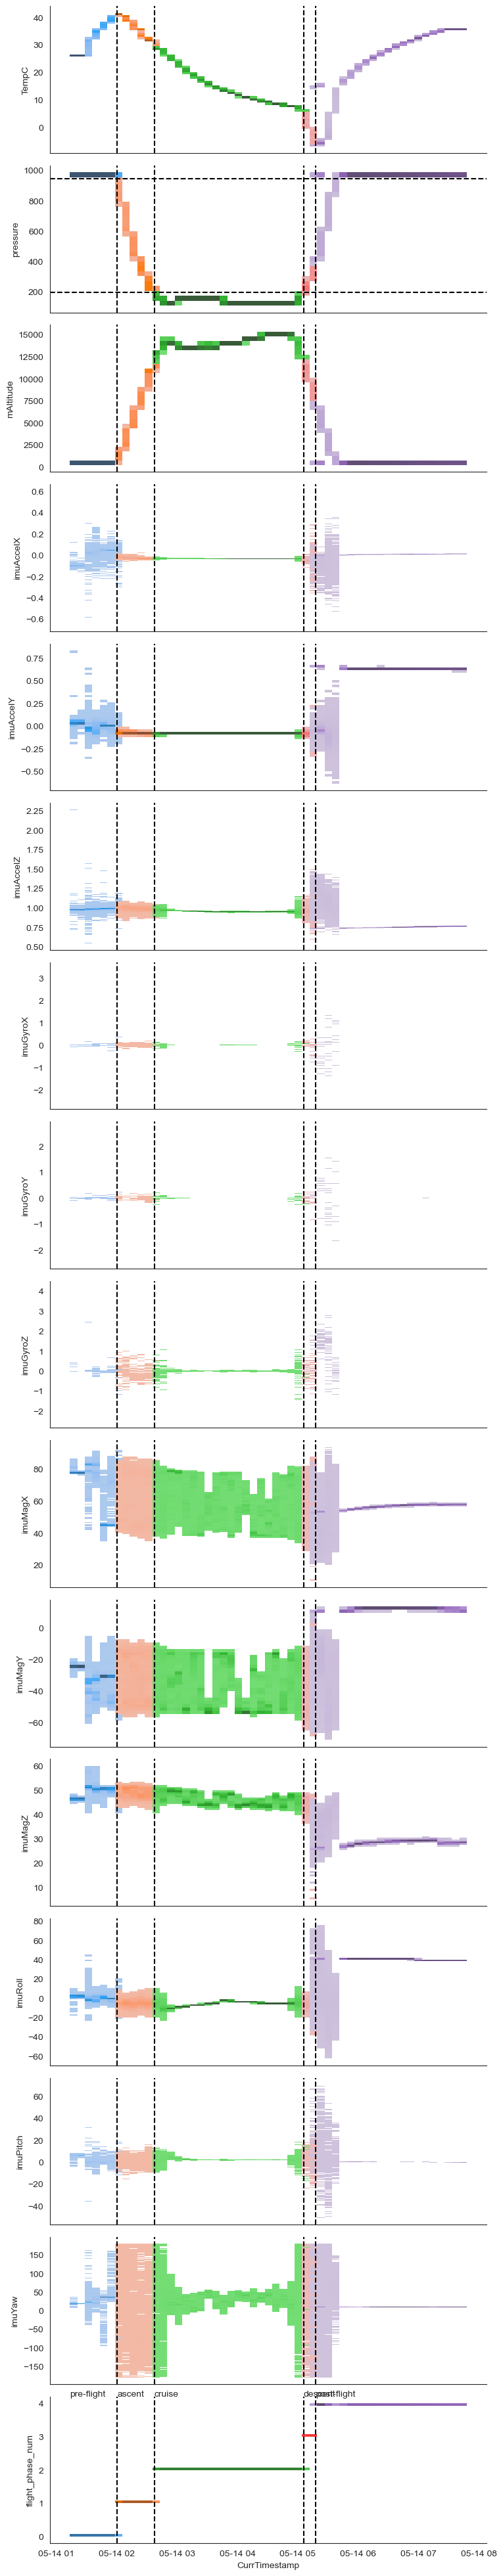

In [23]:
# View versus time
g = sns.PairGrid(imu_log_df, x_vars=['CurrTimestamp'], aspect=3, hue='flight_phase')
g.map_offdiag(sns.histplot)

for ax_row in g.axes:
    ax = ax_row[0]
    
    if ax.get_ylabel() == 'pressure':
        ax.axhline(
            p_landed,
            color = 'k',
            linestyle = '--',
        )
        ax.axhline(
            p_cruising,
            color = 'k',
            linestyle = '--',
        )
    
    for ind in transition_indices:
        ax.axvline(
            imu_log_df.loc[ind,'CurrTimestamp'],
            color = 'k',
            linestyle = '--',
        )
        
min_times = imu_log_df.groupby('flight_phase')['CurrTimestamp'].min()
for phase in min_times.index:
    ax.annotate(
        text = phase,
        xy = (min_times.loc[phase], 1),
        xycoords = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes),
        # xytext = (5,5),
        # textcoords = 'offset points',
    )

In [24]:
# Select cruise data
cruise_data = imu_log_df.loc[imu_log_df['flight_phase'] == 'cruise']
cruise_data = cruise_data.set_index('CurrTimestamp')

In [25]:
# Get rolling deviation
cruise_rolling = cruise_data.rolling(window=pd.Timedelta(rolling_window_in_min, 'min'))
cruise_rolling_std = cruise_rolling.std(numeric_only=True)

In [26]:
# Identify and store steady data
cruise_data.loc[:,'is_steady'] = cruise_rolling_std[column_for_steady] < mult_of_std_for_steady * np.nanmedian(cruise_rolling_std[column_for_steady])
cruise_rolling_std.loc[:,'is_steady'] = cruise_data['is_steady']
imu_log_df['is_steady'] = False
imu_log_df.loc[imu_log_df['flight_phase'] == 'cruise','is_steady'] = cruise_data['is_steady'].values

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

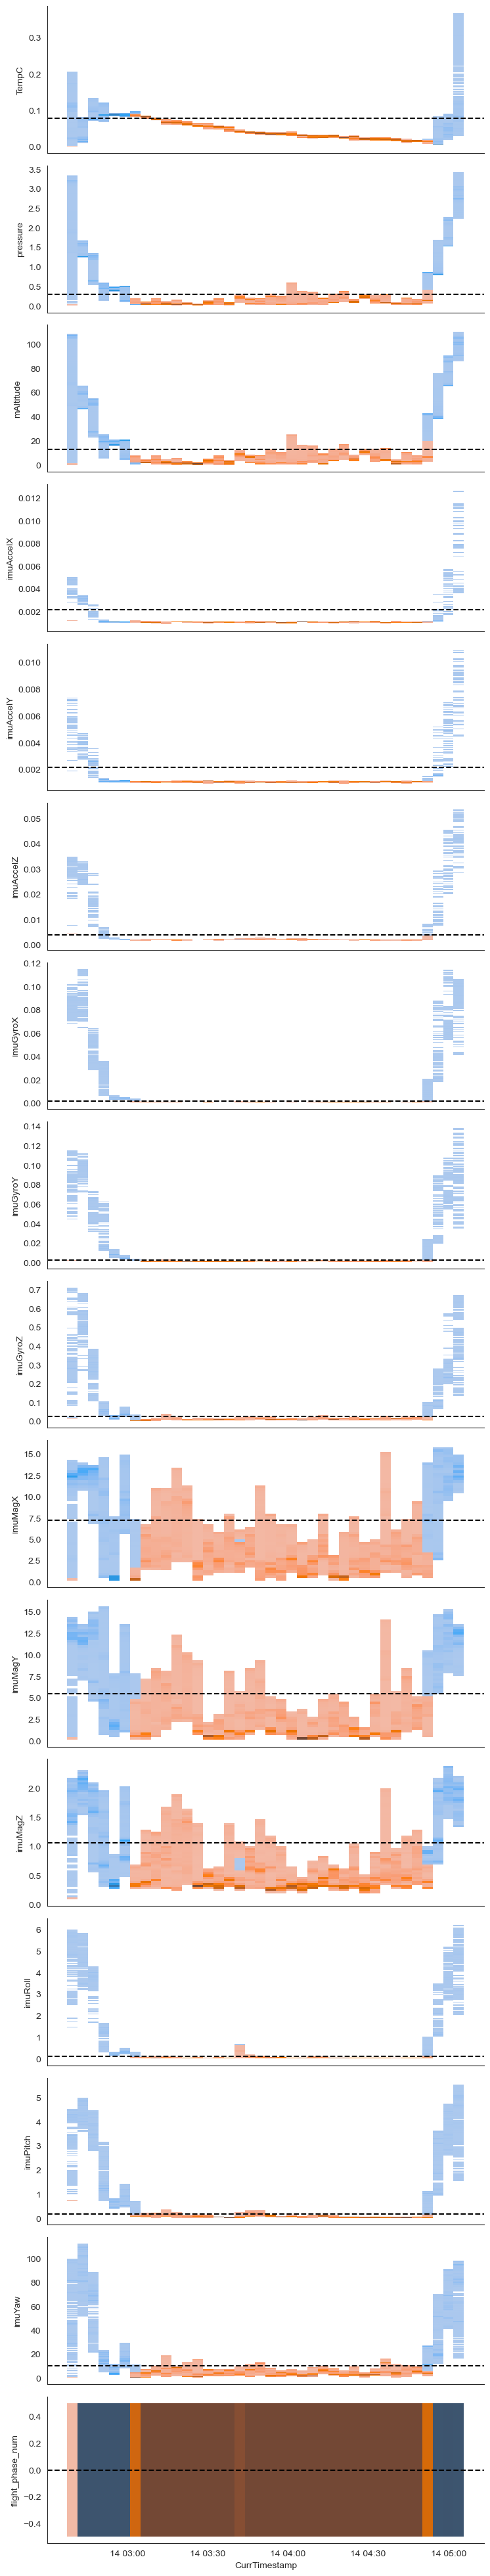

In [27]:
# View versus time
g = sns.PairGrid(cruise_rolling_std.reset_index(), x_vars=['CurrTimestamp'], hue='is_steady', aspect=3)
g.map_offdiag(sns.histplot)

for ax_row in g.axes:
    ax = ax_row[0]
    y_key = ax.get_ylabel()
    med_std = np.nanmedian(cruise_rolling_std[y_key])
    ax.axhline(
        mult_of_std_for_steady * med_std,
        color = 'k',
        linestyle = '--',
    )

### Steady flight visual inspection

This is the cleanest data we could hope for, so let's take a look at it.

In [28]:
steady_data = imu_log_df.loc[imu_log_df['is_steady']]

In [29]:
instruments = {
    'Accel': [ 'imuAccelX', 'imuAccelY', 'imuAccelZ', ],
    'Gyro': [ 'imuGyroX', 'imuGyroY', 'imuGyroZ', ],
    'Mag': [ 'imuMagX', 'imuMagY', 'imuMagZ', ],
    'RollPitchYaw': [ 'imuRoll', 'imuPitch', 'imuYaw', ],
}

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

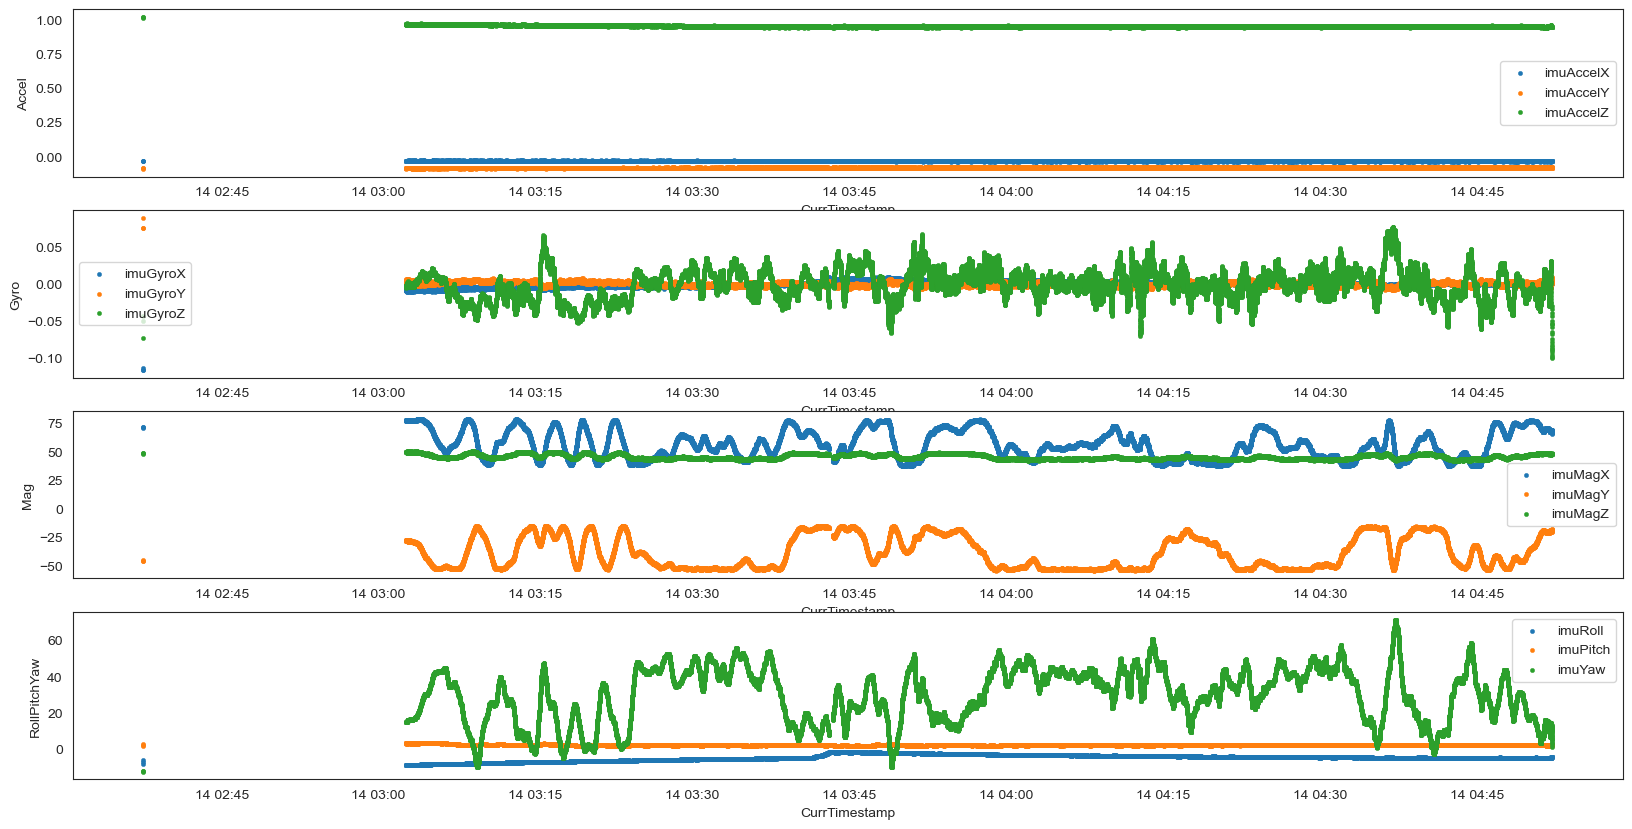

In [30]:
mosaic = [ [ _, ] for _ in instruments.keys() ]

fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(mosaic)

for inst_name, inst_keys in instruments.items():
    
    ax = ax_dict[inst_name]
    
    for inst_key in inst_keys:
        sns.scatterplot(
            steady_data,
            x = 'CurrTimestamp',
            y = inst_key,
            ax = ax,
            edgecolor=None,
            s = 10,
            label = inst_key,
        )
        
    ax.legend()
    ax.set_ylabel(inst_name)

## Compare Match Between IMU and GPS Logs

In [31]:
# Look at acceleration data to identify launch point
accel_data = imu_log_df[['CurrTimestamp', 'imuAccelX', 'imuAccelY', 'imuAccelZ']]
accel_data.set_index('CurrTimestamp', inplace=True)
accel_data = accel_data.dropna()

In [32]:
# Assume the maximum rolling acceleration during the pre-flight marks the launch
accel_rolling_mean = accel_data.rolling(window=pd.Timedelta(rolling_window_in_min*0.5, 'min')).mean()
rolling_mean_mag = np.linalg.norm(accel_rolling_mean, axis=1)
end_of_preflight = imu_log_df.loc[imu_log_df['flight_phase']=='pre-flight', 'CurrTimestamp'].max()
launch_time = accel_data.index[np.argmax(rolling_mean_mag[accel_data.index<end_of_preflight])]

In [33]:
gps_log_df = flight.gps_log_df

In [34]:
# Convert to datetime, toss out recordings not associated with the flight itself.
gps_log_df.drop(gps_log_df.index[gps_log_df['CurrTimestamp'] < pd.to_datetime('2022-5-13 20')], inplace=True)

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

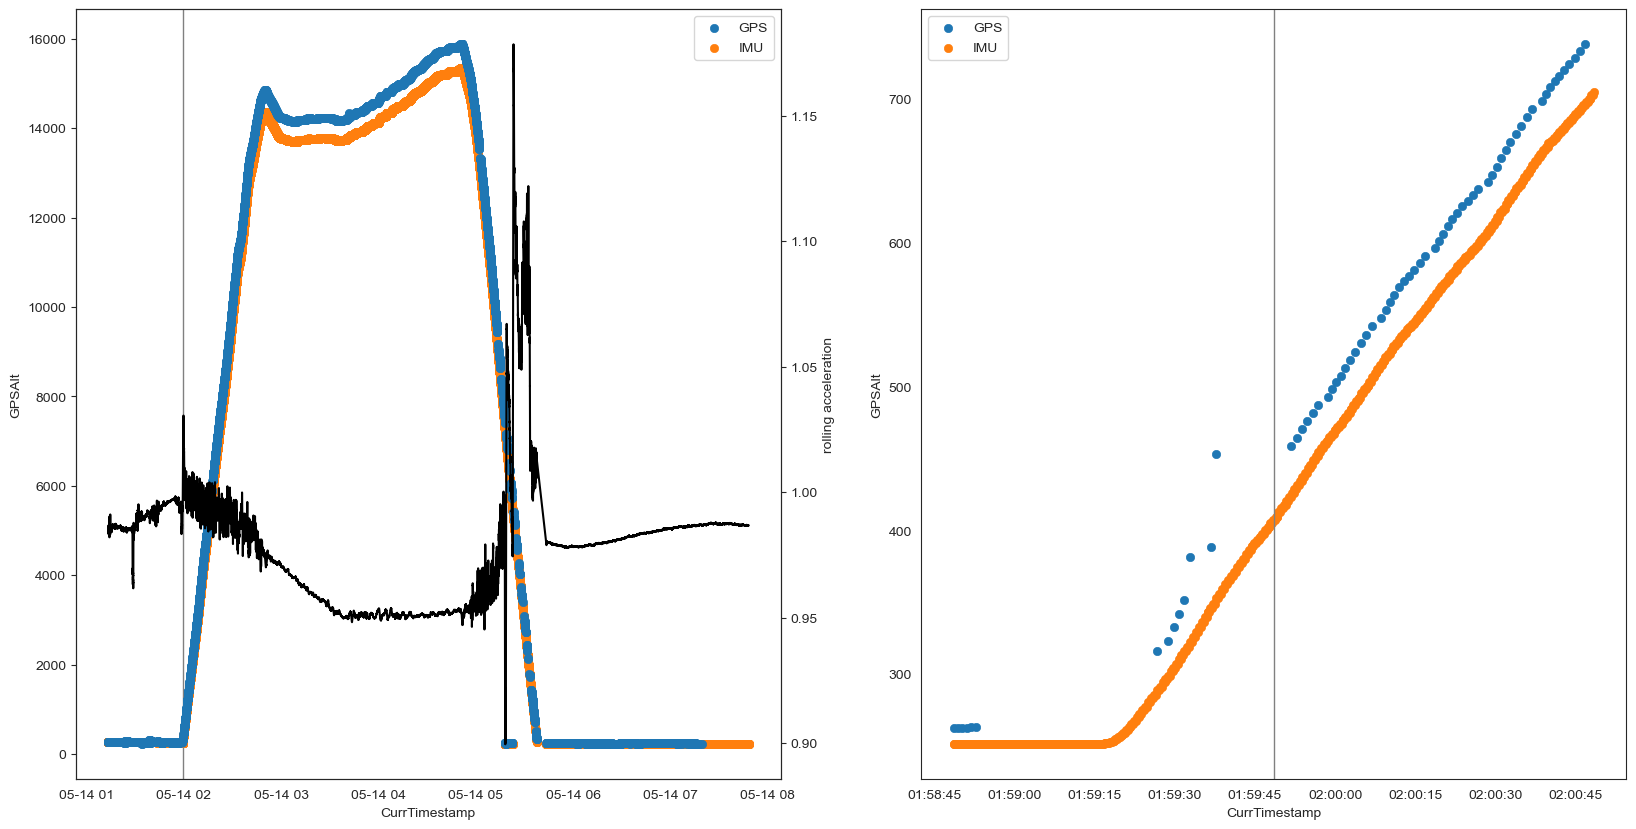

In [35]:
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic([['overall', 'zoomed', ]])

xlims = {
    'overall': None,
    'zoomed': (launch_time - pd.Timedelta(1, 'min'), launch_time + pd.Timedelta(1, 'min')),
}
for ax_key in ['overall', 'zoomed']:
    
    ax = ax_dict[ax_key]
    
    if xlims[ax_key] is not None:
        gps_selected = gps_log_df.loc[(
            (gps_log_df['CurrTimestamp'] > xlims[ax_key][0]) &
            (gps_log_df['CurrTimestamp'] < xlims[ax_key][1])
        )]
        imu_selected = imu_log_df.loc[(
            (imu_log_df['CurrTimestamp'] > xlims[ax_key][0]) &
            (imu_log_df['CurrTimestamp'] < xlims[ax_key][1])
        )]
    else:
        gps_selected = gps_log_df
        imu_selected = imu_log_df
    
    sns.scatterplot(
        gps_selected,
        x = 'CurrTimestamp',
        y = 'GPSAlt',
        edgecolor = None,
        label = 'GPS',
        ax = ax,
        zorder = 100,
    )
    sns.scatterplot(
        imu_selected,
        x = 'CurrTimestamp',
        y = 'mAltitude',
        edgecolor = None,
        label = 'IMU',
        ax = ax,
    )
    
    ax.axvline(
        launch_time,
        color = '0.5',
        linewidth = 1,
    )
    
    if ax_key == 'overall':
        ax2 = ax.twinx()
        ax2.plot(
            accel_data.index,
            rolling_mean_mag,
            color = 'k',
        )
        ax2.set_ylabel('rolling acceleration')
    ax.legend()
    
# ax.scatter(
#     gps_log_df['CurrT
# )

The match-up between the GPS and IMU data is not bad. We'll try using them as-is. The magnitude of the acceleration matches with the launch time to within a minute, but is still off by ~30 seconds.

# Image Calibration

## Inspect a Random Image

In [36]:
# Random observation
ind = rng.choice(flight.metadata.index[flight.metadata['valid_filepath']])
obs = flight.get_observation(ind)

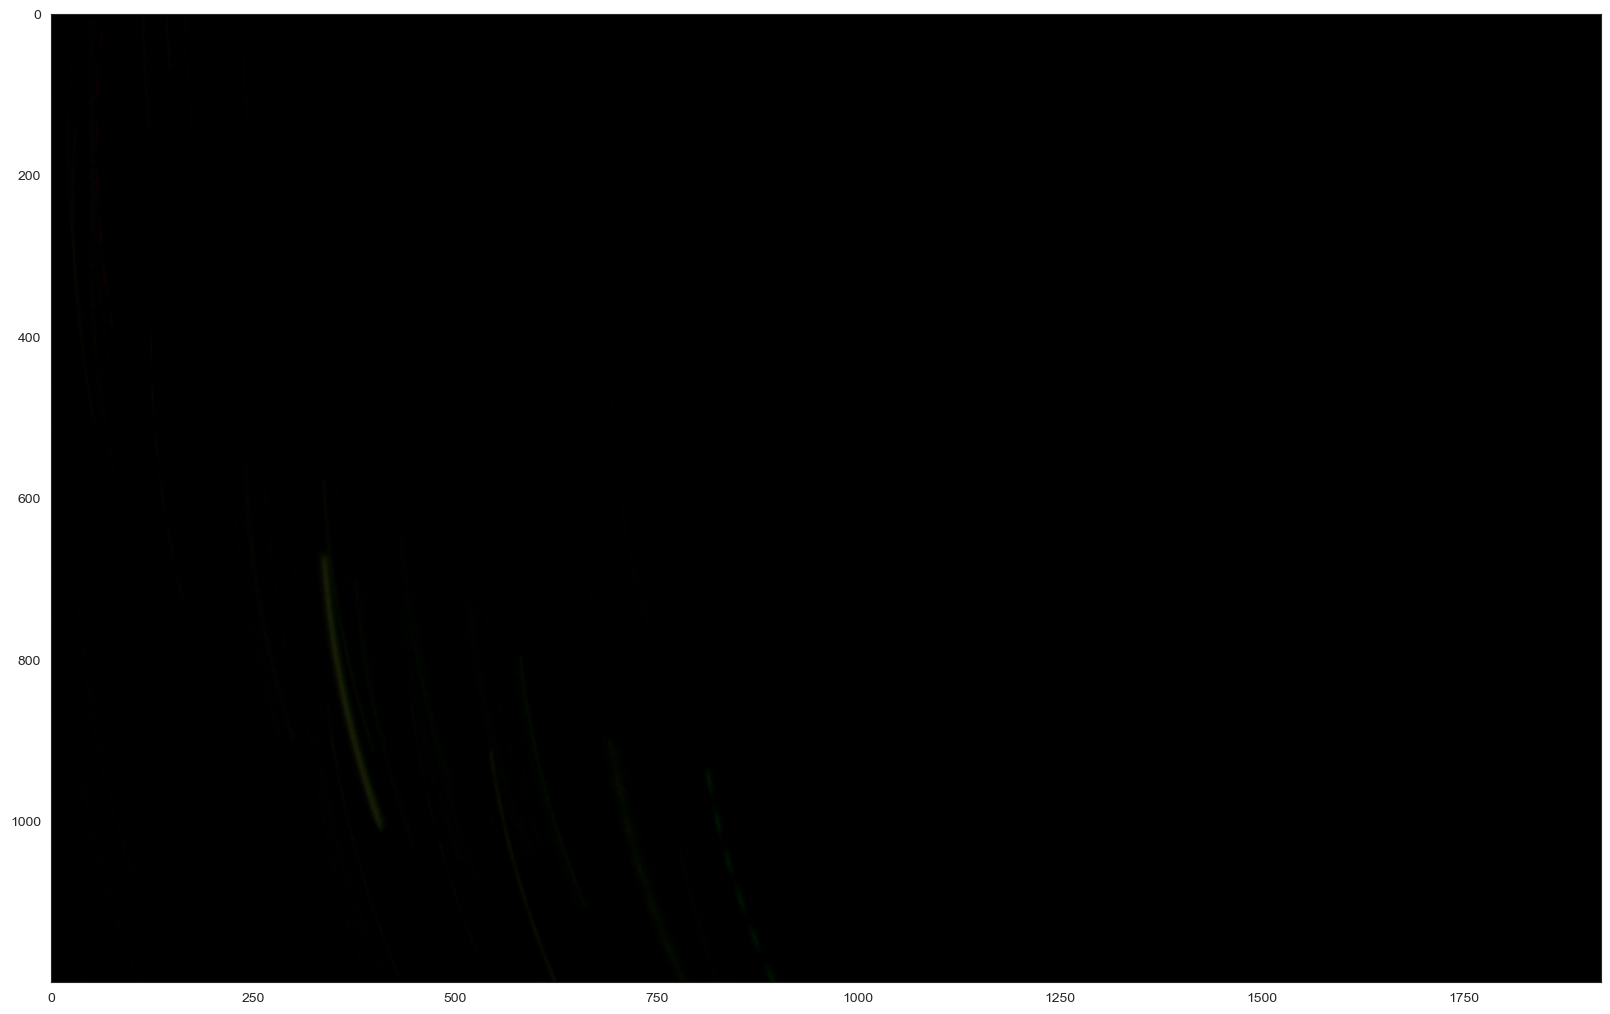

In [37]:
obs.show()

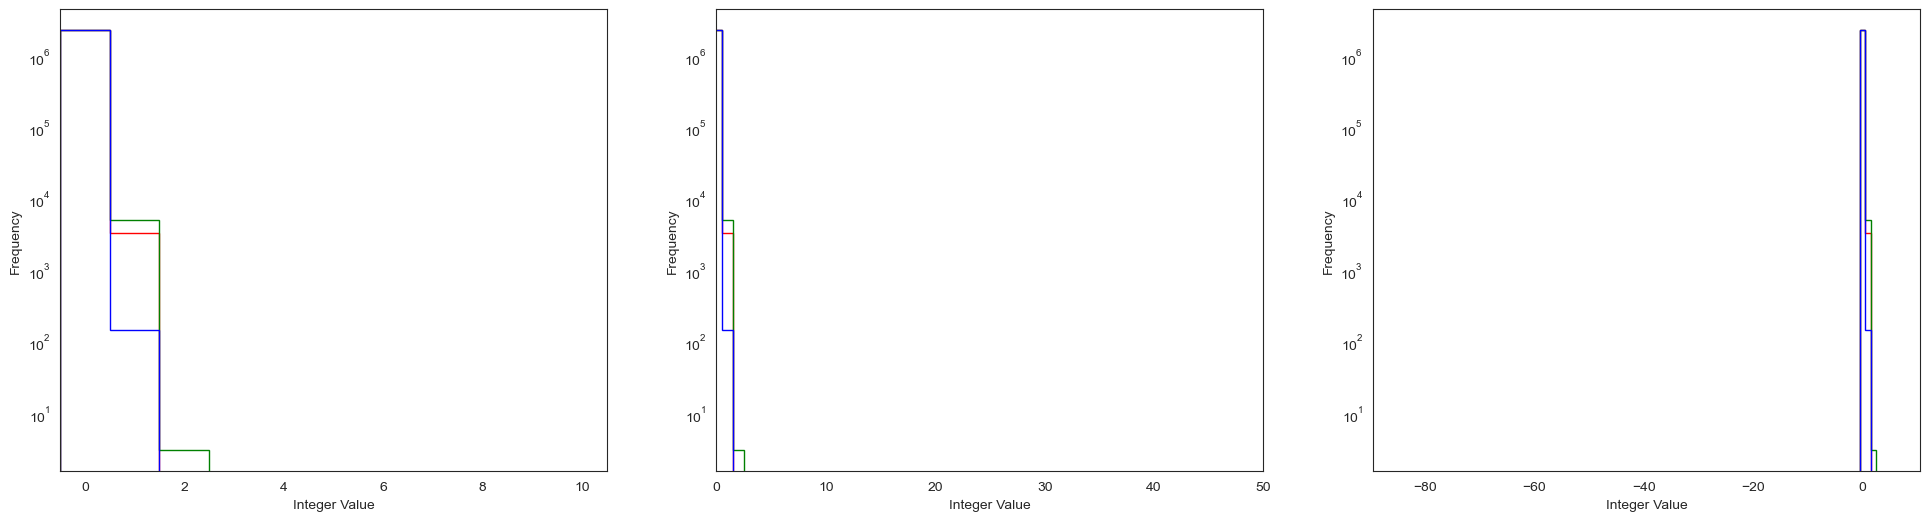

In [38]:
max_val = flight.bit_precisions['.raw']
bins = np.arange(-0.5, max_val-0.5, 1)
plt_types = ['big_picture', 'zoomed', 'zoomed_upper']

# Look at brightness distribution
fig = plt.figure(figsize=(8*len(plt_types),6))

xlims = [ (bins[0], bins[-1]), (0, 50), (bins[-1]-100, bins[-1]) ]
ax_dict = fig.subplot_mosaic([plt_types,])

colors = ['red', 'green', 'blue']
for j, plt_type in enumerate(plt_types):
    
    ax = ax_dict[plt_types[j]]
    for i, color in enumerate(colors):
        
        arr = obs.img[:,:,i] * max_val

        ax.hist(
            arr.flatten(),
            bins = bins,
            color = color,
            histtype = 'step',
        )
        ax.set_xlim(xlims[j])

    ax.set_yscale('log')
    
    ax.set_xlabel( 'Integer Value', )
    ax.set_ylabel( 'Frequency', )

## Inspect a Calibration Image

In [39]:
cal_image_dir = os.path.join( google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Calibration Tests/3.19.22 Complete Calib Set/23085686_1sec_flatFrames' )

In [40]:
fp = rng.choice(glob.glob(os.path.join(cal_image_dir, '*.raw')))

In [41]:
# Open the image, assuming same settings as actual flight data.
img = observations.load_rgb_img(
    fp,
    img_shape=flight.img_shape,
    bit_precisions=flight.bit_precisions,
)

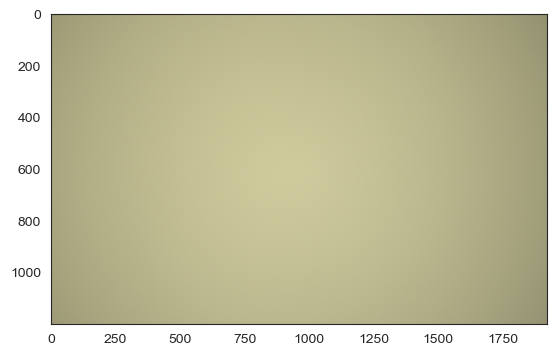

In [42]:
plt.imshow(img)

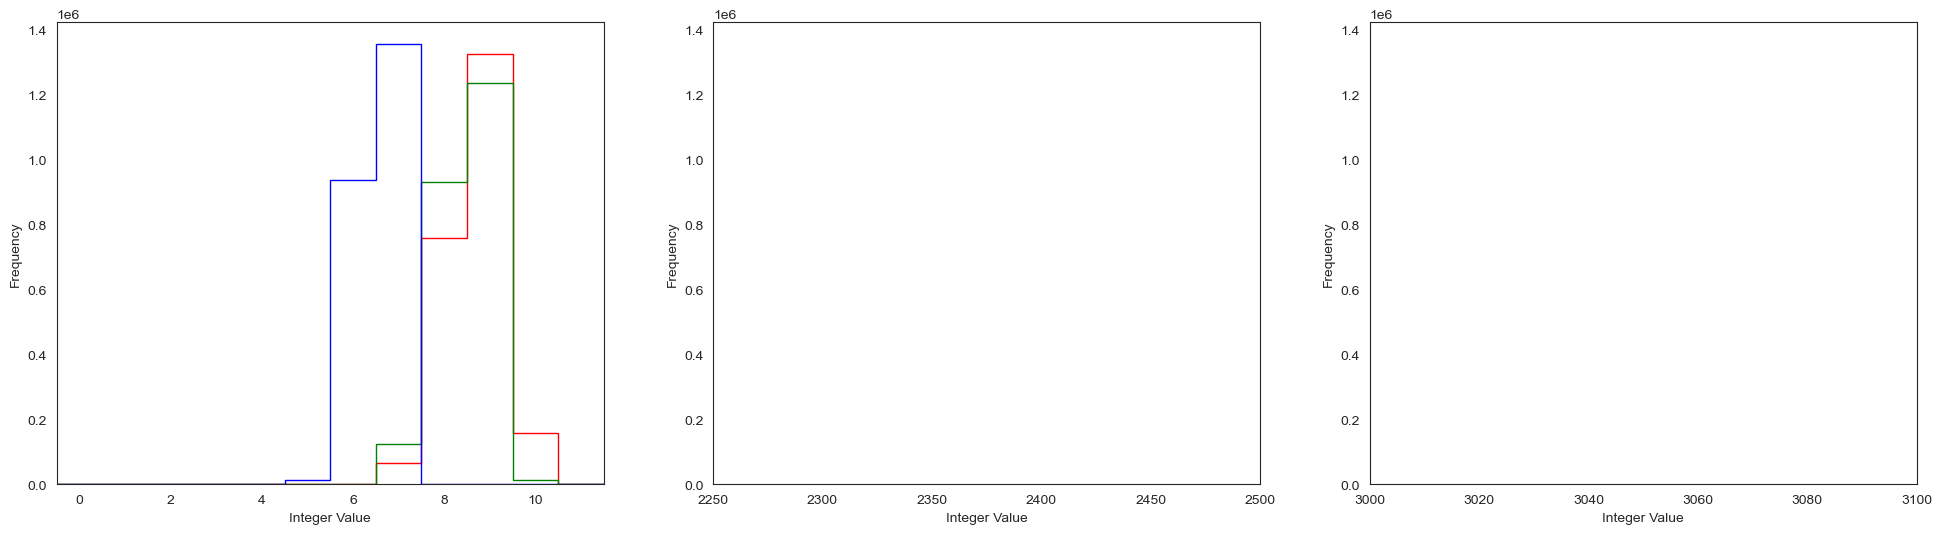

In [43]:
bins = np.arange(-0.5, max_val, 1)
plt_types = ['big_picture', 'zoomed', 'zoomed_upper']

# Look at brightness distribution
fig = plt.figure(figsize=(8*len(plt_types),6))

xlims = [(bins[0], bins[-1]), (2250, 2500), (3000, 3100)]
ax_dict = fig.subplot_mosaic([plt_types,])

colors = ['red', 'green', 'blue']
for j, plt_type in enumerate(plt_types):
    
    ax = ax_dict[plt_types[j]]
    for i, color in enumerate(colors):
        
        arr = img[:,:,i] * max_val

        ax.hist(
            arr.flatten(),
            bins = bins,
            color = color,
            histtype = 'step',
        )
        ax.set_xlim(xlims[j])

    # ax.set_yscale('log')
    
    ax.set_xlabel( 'Integer Value', )
    ax.set_ylabel( 'Frequency', )

# Extra Metadata Processing

In [44]:
metadata = flight.metadata

In [45]:
# We'll keep track of what images we expect to be valid along the way
metadata['valid'] = True

# Manually Geo-Referenced Images

## Example Image

In [46]:
# Choose a random geo-referenced image
reffed_fps = metadata['manually_referenced_fp']
reffed_fps = reffed_fps.loc[reffed_fps.notna()]
ind_displayed = rng.choice(reffed_fps.index)
# man_fp = metadata.loc[ind_displayed,'manually_referenced_fp']

### Raw Image Data

In [47]:
reffed_obs = flight.get_referenced_observation(ind_displayed)

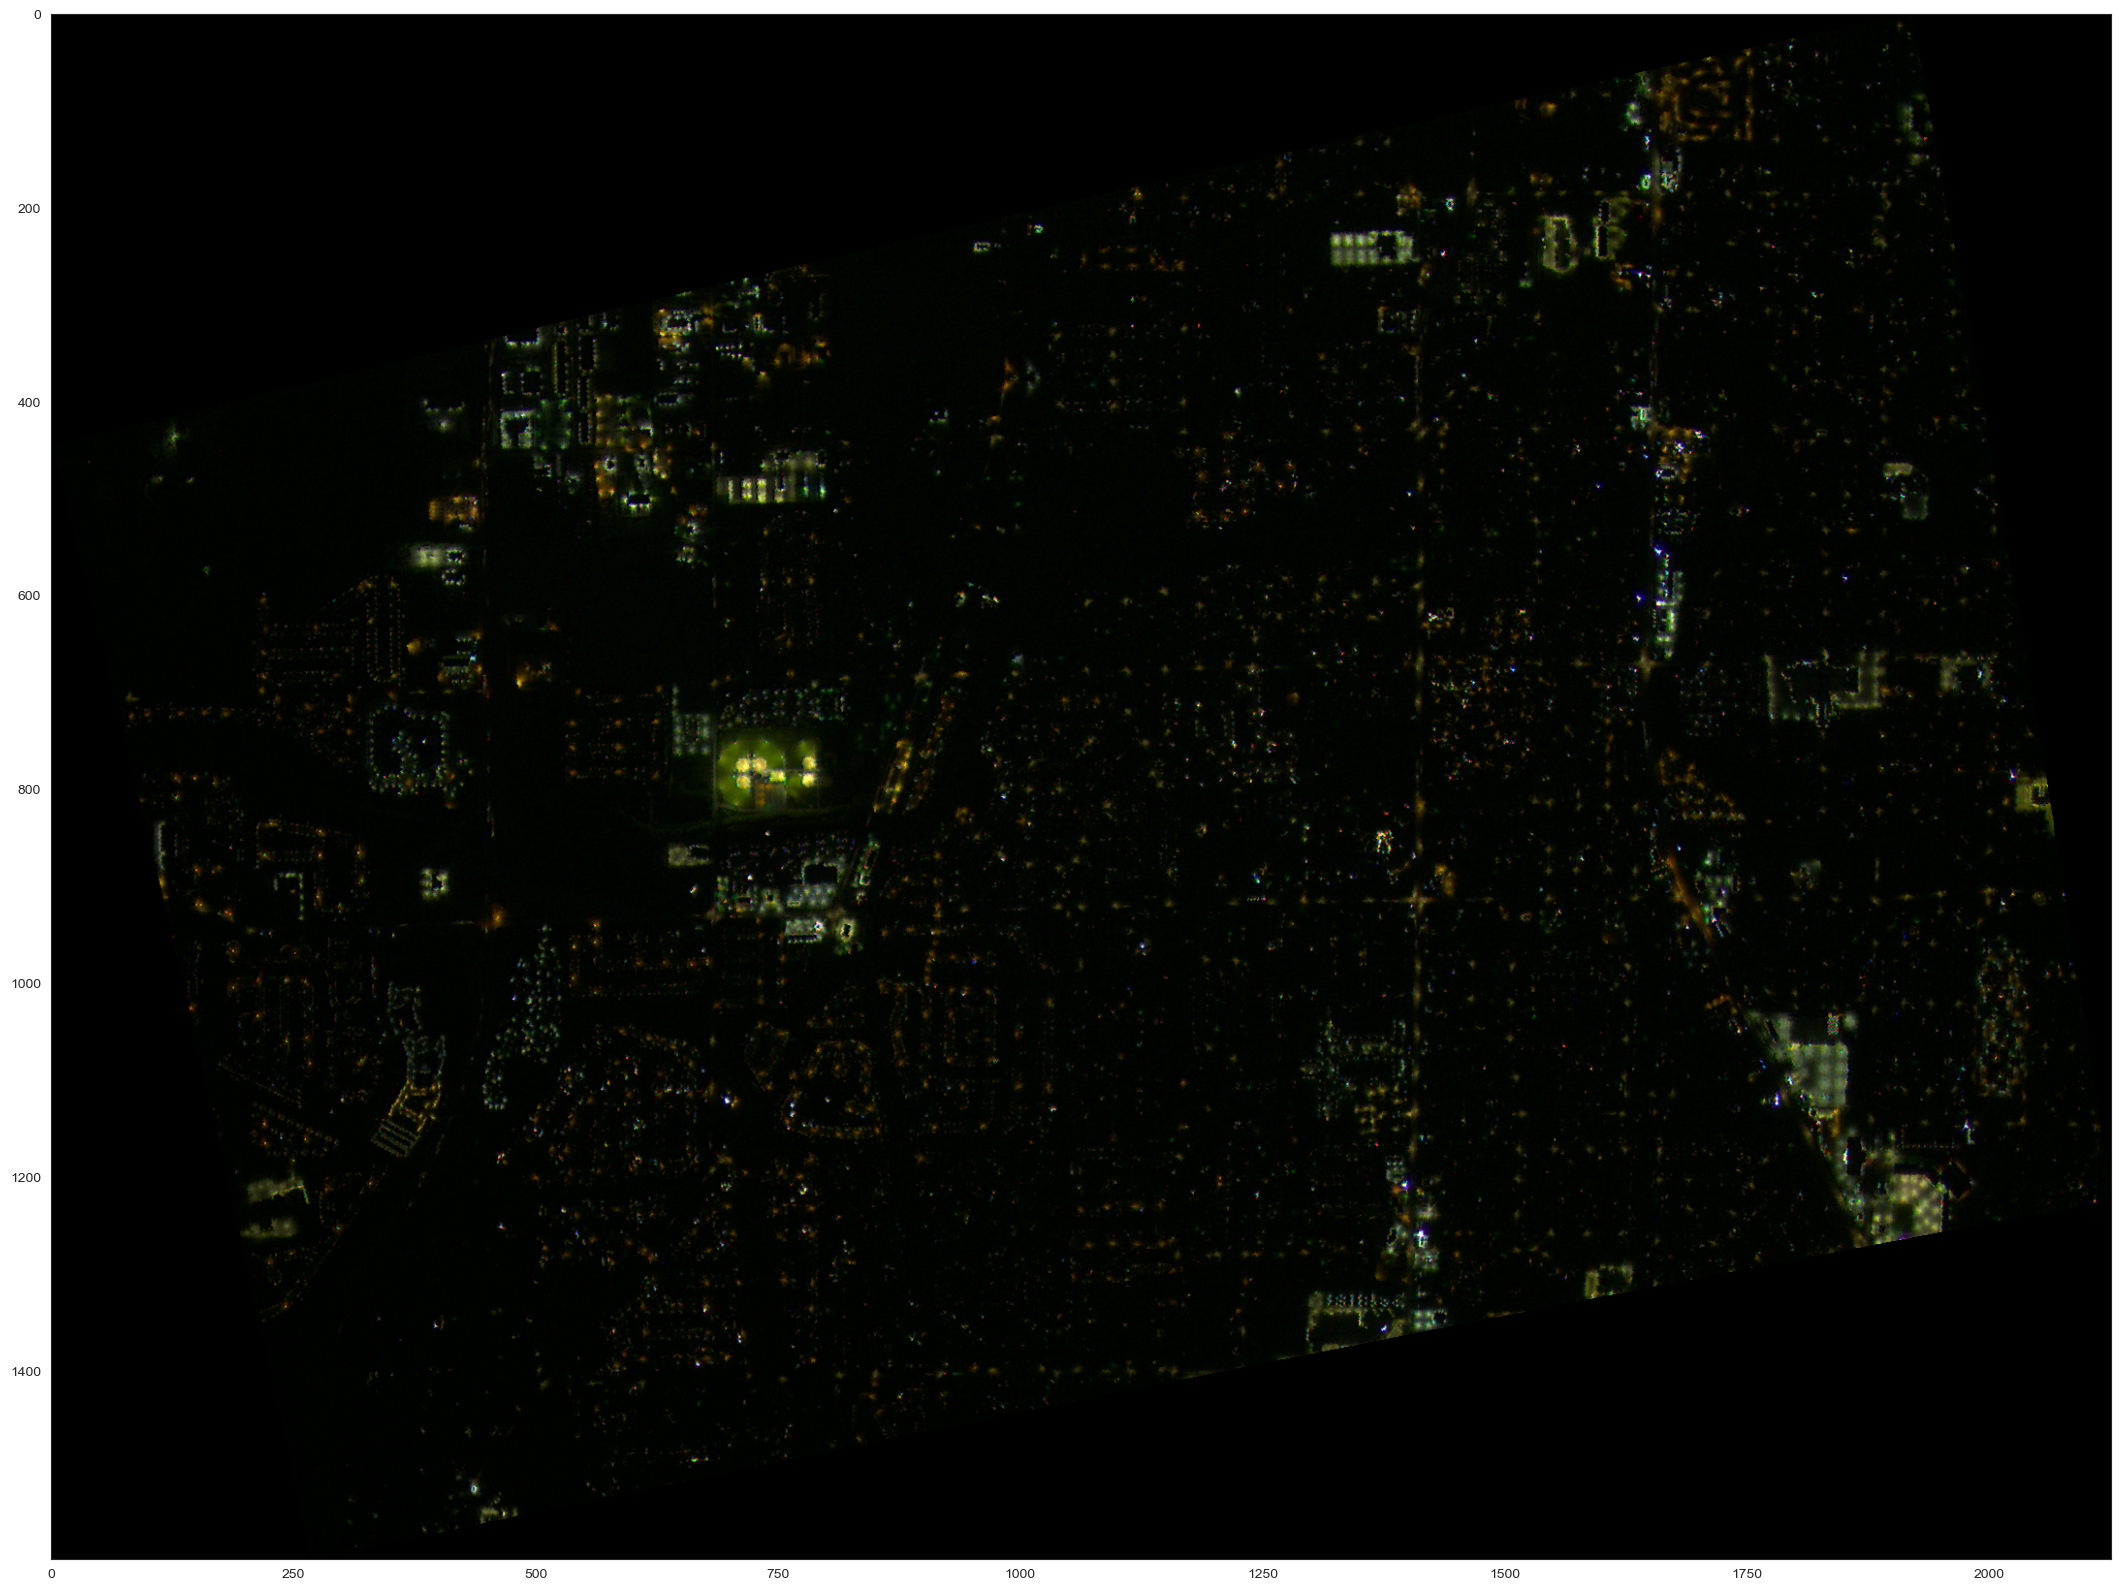

In [48]:
reffed_obs.show()

### As a GeoTIFF

In [49]:
# Get latitude of image
reffed_lon_bounds, reffed_lat_bounds = reffed_obs.get_latlon_bounds()

In [50]:
# Show in the context of a coordinate system
reffed_obs.show_in_cart_crs()

TypeError: Bbox.from_bounds() takes 4 positional arguments but 5 were given

### Sentinel-2 Data

In [ ]:
# Sentinel-2 data. Checked on Earth engine and this provides nice urban images of Indianapolis
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
# Semi-arbitrary date range
s2 = s2.filterDate('2020-01-01', '2020-01-30') 
 # Let's not try to process things that are too cloudy
s2 = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

In [ ]:
def get_filtered_img(img):
    '''Get the image, masking cloudy data pre-aggregation.
    '''
    
    # Select cloud mask layer
    qa = img.select('QA60')

    # Setup bitmask
    cloud_bitmask = 1 << 10
    cirrus_bitmask = 1 << 11

    # Get mask
    is_not_cloudy = qa.bitwise_and(cloud_bitmask).eq(0)
    is_not_cirrusy = qa.bitwise_and(cirrus_bitmask).eq(0)
    is_valid = is_not_cloudy and is_not_cirrusy

    img = img.updateMask(is_valid)

    # Scale image by scale given in dataset description
    return img.divide(10000.) 
s2_filtered = s2.map(get_filtered_img)

In [ ]:
s2_img = s2_filtered.mean()

### Visualize

In [ ]:
# Create map
location = (np.mean(lat_bounds_man), np.mean(lon_bounds_man))
m = folium.Map(location, zoom_start=13)

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Add S2 image
mosaic_center_point = ee.Geometry.Point(location, proj=latlon_crs_code)
vis_params = {
    'region': mosaic_center_point.buffer(10000.),
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}
m.add_ee_layer(s2_img, vis_params, 's2')

In [ ]:
# Add manual image
folium.raster_layers.ImageOverlay(
    dataset.ReadAsArray().transpose(1,2,0),
    bounds=[[lat_bounds_man[0], lon_bounds_man[0]], [lat_bounds_man[1], lon_bounds_man[1]]],
    name='manually georeferenced',
).add_to(m)

In [ ]:
# Markers for the corners so we can understand how the image pixels get flipped around
bounds_group = folium.FeatureGroup(name='bounds')
minmax_labels = ['min', 'max']
for ii in range(2):
    for jj in range(2):
        folium.Marker(
            [lat_bounds_man[ii], lon_bounds_man[jj]],
            popup=f'(x_{minmax_labels[jj]}, y_{minmax_labels[ii]})',
            icon=folium.Icon(color='gray',icon_color=palette.as_hex()[jj*2 + ii]),
        ).add_to(bounds_group)
bounds_group.add_to(m)

In [ ]:
# # Add widgets
# m.add_child(folium.LayerControl())
# print('Layer control added.')

In [ ]:
# m

## Second Example Image

In [ ]:
# Second img to display. Will act as a mosaic
reffed = metadata.loc[metadata['manually_referenced_fp'].notna()]
iloc_displayed = np.arange(reffed.index.size)[reffed.index == ind_displayed][0]
ind_displayed2 = reffed.index[iloc_displayed + 1]
row2 = reffed.loc[ind_displayed2]
man_fp2 = row2['manually_referenced_fp']
man_img2, man_img2_int = load_man_img(man_fp2, k_rot=0)

In [ ]:
# As a GDAL dataset
dataset2 = gdal.Open(man_fp2)

In [ ]:
# Get latitude and longitude of corner
lon_bounds_man2, lat_bounds_man2 = dataset2.get_bounds()

In [ ]:
# Pixel coordinates
x_bounds_man2, y_bounds_man2 = dataset2.get_bounds(cart_crs)
pixel_xs2 = np.linspace(x_bounds_man2[0], x_bounds_man2[1], man_img2_int.shape[1])
pixel_ys2 = np.linspace(y_bounds_man2[0], y_bounds_man2[1], man_img2_int.shape[0])

In [ ]:
# Add to interactive map
folium.raster_layers.ImageOverlay(
    dataset2.ReadAsArray().transpose(2,1,0),
    bounds=[[lat_bounds_man2[0], lon_bounds_man2[0]], [lat_bounds_man2[1], lon_bounds_man2[1]]],
    name='manually georeferenced 2',
).add_to(m)

In [ ]:
# Add widgets
m.add_child(folium.LayerControl())
print('Layer control added.')

In [ ]:
m

## Coordinate Conversion

In [ ]:
man_coords_fp = os.path.join(manually_reffed_dir, 'img_coordinates_{}.csv'.format(cart_crs.srs.replace(':', '')))

In [ ]:
if os.path.exists(man_coords_fp) and not overwrite_manual_referencing:
    manually_referenced = pd.read_csv(man_coords_fp, index_col=0)
else:
    calculated = {
        'man_img_x_min': [],
        'man_img_x_max': [],
        'man_img_y_min': [],
        'man_img_y_max': [],
    }

    for i in tqdm.tqdm(range(len(man_fps))):

        man_fp = man_fps.iloc[i]
        ind = man_fps.index[i]
        row = metadata.loc[ind]

        dataset = gdal.Open(man_fp)
        x_lim_man, y_lim_man = dataset.get_bounds(cart_crs)

        calculated['man_img_x_min'].append(x_lim_man[0])
        calculated['man_img_x_max'].append(x_lim_man[1])
        calculated['man_img_y_min'].append(y_lim_man[0])
        calculated['man_img_y_max'].append(y_lim_man[1])

    # Make a dataframe
    manually_referenced = pd.DataFrame(calculated)
    manually_referenced.index = man_fps.index
    manually_referenced['filename'] = metadata['manually_referenced_fp'].str.split('/').str[-1]

    # Save
    manually_referenced.to_csv(man_coords_fp)

In [ ]:
# Manual image centers
manually_referenced['man_x_center'] = 0.5 * (manually_referenced['man_img_x_min'] + manually_referenced['man_img_x_max'])
manually_referenced['man_y_center'] = 0.5 * (manually_referenced['man_img_y_min'] + manually_referenced['man_img_y_max'])

In [ ]:
# Manual image dimensions
manually_referenced['man_img_width'] = manually_referenced['man_img_x_max'] - manually_referenced['man_img_x_min']
manually_referenced['man_img_height'] = manually_referenced['man_img_y_max'] - manually_referenced['man_img_y_min']
manually_referenced['man_img_hypotenuse'] = np.sqrt(manually_referenced['man_img_width']**2. + manually_referenced['man_img_height']**2.)

In [ ]:
# Compare how far off the manual images are from the bottom
man_metadata = metadata.loc[metadata['manually_referenced_fp'].notna()]
man_dx = manually_referenced['man_x_center'] - man_metadata['sensor_x']
man_dy = manually_referenced['man_y_center'] - man_metadata['sensor_y']
man_dz = ground_alt - man_metadata['mAltitude']

In [ ]:
# Estimate angle from the manual images
man_v = np.array([man_dx, man_dy, man_dz]).transpose()
man_distance =  np.linalg.norm(man_v, axis=1)
man_vhat = man_v / man_distance[:,np.newaxis]

# Georeferencing with Metadata

## Rotate to get best match to manual

In [ ]:
# Rotations are confusing, so let's just see what produces the best fit
median_dotproducts = []
xyz_combos = []
rollpitchyaw_combos = []
median_relative_errors = []
for case in ['upper', 'lower']:
    letters = getattr('xyz', case)()
    for xyz_combo in permutations(letters):
        for rollpitchyaw_combo in permutations(['imuRoll', 'imuPitch', 'imuYaw']):
            
            # Format
            xyz_combo = ''.join(xyz_combo)
            rollpitchyaw_combo = list(rollpitchyaw_combo)
            
            # Get the rotation object
            rot_comp = scipy.spatial.transform.Rotation.from_euler(
                xyz_combo,
                man_metadata[rollpitchyaw_combo],
                degrees=True,
            )
            vhat_comp = rot_comp.apply([0., 0., -1.])
            
            # Calculate agreement
            dotproducts = (man_vhat * vhat_comp).sum(axis=1)
            
            # Convert into intepretable error
            projected_error = man_distance * np.sin(np.arccos(dotproducts))
            relative_errors = projected_error / manually_referenced['man_img_hypotenuse']
            
            median_dotproducts.append(np.median(dotproducts))
            xyz_combos.append(xyz_combo)
            rollpitchyaw_combos.append(rollpitchyaw_combo)
            median_relative_errors.append(np.median(relative_errors))

In [ ]:
# Summarize output
best_fit_inds = np.argsort(median_relative_errors)[:10]
for best_fit_ind in best_fit_inds:
    print('ind = {}, median dot prod = {:.4g}, median relative error = {:.3g}'.format(best_fit_ind, median_dotproducts[best_fit_ind], median_relative_errors[best_fit_ind]))
    print('    {}, {}'.format(xyz_combos[best_fit_ind], rollpitchyaw_combos[best_fit_ind]))

In [ ]:
man_offset = np.sqrt(man_dx**2. + man_dy**2.)
imu_not_used_median_relative_error = np.median(man_offset / manually_referenced['man_img_hypotenuse'])
print('For comparison, the median relative error assuming the image is directly below is {:.3g}'.format(imu_not_used_median_relative_error))

In [ ]:
# Select best fit
best_fit_ind = best_fit_inds[0]
xyz_combo = xyz_combos[best_fit_ind]
rollpitchyaw_combo = rollpitchyaw_combos[best_fit_ind]

In [ ]:
# Get the rotation object
rot_comp = scipy.spatial.transform.Rotation.from_euler(
    xyz_combo,
    man_metadata[rollpitchyaw_combo],
    degrees=True,
)
vhat_comp = rot_comp.apply([0., 0., -1.])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

coord_names = ['x', 'y', 'z']
for i in range(3):
    coord_name = coord_names[i]
        
    ax.scatter(
        man_vhat[:,i],
        vhat_comp[:,i],
        color = palette[i],
        label = '{} component'.format(coord_name),
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    ax.grid()
    
    ax.set_xlabel(r'manually-referenced $\hat v_i$')
    ax.set_ylabel(r'IMU-derived $\hat v_i$')
    
ax.legend()

In [ ]:
# Place back
metadata = pd.concat([metadata, manually_referenced], axis='columns')
metadata = metadata.loc[:,~metadata.columns.duplicated()]

In [ ]:
# Get the rotation object
rot = scipy.spatial.transform.Rotation.from_euler(
    'XZY',
    metadata[['imuPitch', 'imuYaw', 'imuRoll']],
    degrees=True,
)

## Calculate Center and Radius in Local Coords

Given a sensor with position vector $\vec p$ pointed in direction $\hat v$ we want to find the position vector of the source image,

\begin{equation}
\vec s = \vec p + \vec v
\end{equation}

The main unknown in this equation is the magnitude of $\vec v$.
Assuming the sensor is a height $h$ above a flat surface then $h\, /\, \mid \vec v \mid = \cos \phi$, where $\phi$ is the angle between a line connecting the ground and the sensor and $\hat v$.
If $\theta$ is the standard spherical angle determining the z-component of $\hat v$ then $\phi = \pi - \theta$.
Doing some algebra we get $\mid \vec v \mid = - h\,/\, \mid\hat v_z \mid$.
Plugging in and simplifying, we get

\begin{equation}
\vec s = (p_x - h \mid\hat v_x \mid / \mid\hat v_z \mid) \hat x + (p_y - h \mid\hat v_y \mid / \mid\hat v_z \mid) \hat y
\end{equation}

In practice we'll often set $\vec p = \langle 0, 0, h \rangle$ and then deal with the conversion to a uniform reference frame during the conversion to geo-coordinates, simplifying this to 
\begin{equation}
\vec s = \langle - h \mid\hat v_x \mid / \mid\hat v_z \mid,\,\, - h \mid\hat v_y \mid / \mid\hat v_z \mid \rangle
\end{equation}

This is the general solution for any $\hat v$, but the special case we care most about is the center of the image.

In [ ]:
# Height above ground
height = metadata['mAltitude'] - ground_alt

# Negative height is no good.
metadata.loc[height<0, 'valid'] = False

In [ ]:
# Get image centers
vhat_sensor_center = rot.apply([0, 0, -1])
d_to_src = - height.values / vhat_sensor_center[:,2]
image_center_coords = d_to_src[:,np.newaxis] * vhat_sensor_center[:,:2]
metadata[['img_center_dx', 'img_center_dy']] = image_center_coords
metadata['img_center_tilt'] = np.arccos(-vhat_sensor_center[:,2]) * 180. / np.pi

In addition to the center of the vector, we'd like to estimate a radius $r$ which we expect to enclose the image.
This radius should account for both (a) geometric effects and (b) error in georeferencing.
We can parameterize this radius according to an angle $\xi = \epsilon \alpha$ where $\alpha$ is the angular radius of the image and $\epsilon$ is a multiplicative error term.
Then, neglecting warping from the image being captured at an angle (for the radius we'll assume that this is wrapped into $\epsilon$),

\begin{align}
r &= \mid\vec v \mid \tan \xi \\
&= - h\,/\, \mid\hat v_z \mid \tan( \epsilon \alpha)
\end{align}

In [ ]:
# We'll estimate the angular radius of the image as the angular width of
# the sensor multiplied by the ratio of the image diagonal to image width
angular_radius = img_angular_error * (img_angular_width / 2.) * (np.linalg.norm(flight.img_shape) / flight.img_shape[1])
img_radius = np.abs(d_to_src * np.tan(angular_radius * np.pi / 180.))
metadata['img_radius'] = img_radius

In [ ]:
# Anything where the angular radius overlaps the horizon
# (i.e. the picture is partially of the horizon)
# is also no good
max_center_angle = 90. - angular_radius
is_sideways = -vhat_sensor_center[:,2] < np.cos(max_center_angle * np.pi / 180.)
metadata.loc[is_sideways, 'valid'] = False

In [ ]:
# We can see that the radius of the image is typically ~0.4 * the height
_ = plt.hist(img_radius[metadata['valid']] / height.loc[metadata['valid']], bins=64)

In [ ]:
# Get image centers
metadata['img_center_x'] = metadata['sensor_x'] + metadata['img_center_dx']
metadata['img_center_y'] = metadata['sensor_y'] + metadata['img_center_dy']
metadata['img_center_lat'], metadata['img_center_lon'] = cart_to_latlon.transform(metadata['img_center_x'], metadata['img_center_y'])

## Calculate image edges in Geo-coordinates

In [ ]:
negpos = [-1., 1.]
corner_keys = []
for i, h_letter in enumerate(['l', 'r']):
    for j, v_letter in enumerate(['l', 'u']):
        
        # Get angle in sensor frame
        rot_img_corner = scipy.spatial.transform.Rotation.from_euler(
            'yxz',
            [negpos[i]*img_angular_width/2., negpos[j]*img_angular_height/2., 0],
            degrees=True,
        )
        vhat_corner_sensor_frame = rot_img_corner.apply([0., 0., -1.])
        
        # Angle in base frame
        vhat = rot.apply(vhat_corner_sensor_frame)
        
        # Distance to source assuming flat surface
        d_to_src = - height.values / vhat[:,2]
        
        corner_key = '{}{}'.format(v_letter, h_letter)
        
        metadata['img_{}_x'.format(corner_key)] = metadata['sensor_x'] + d_to_src * vhat[:,0]
        metadata['img_{}_y'.format(corner_key)] = metadata['sensor_y'] + d_to_src * vhat[:,1]
        
        metadata['img_{}_lat'.format(corner_key)], metadata['img_{}_lon'.format(corner_key)] = cart_to_latlon.transform(
            metadata['img_{}_x'.format(corner_key)],
            metadata['img_{}_y'.format(corner_key)]
        )
        
        corner_keys.append(corner_key)

In [ ]:
for xory in ['x', 'y']:
    corner_xorys = metadata[['img_{}_{}'.format(_, xory) for _ in corner_keys]]
    metadata['img_{}_min'.format(xory)] = corner_xorys.min(axis='columns')
    metadata['img_{}_max'.format(xory)] = corner_xorys.max(axis='columns')

In [ ]:
# Compare radius to actual image radius
actual_radius = np.sqrt(
    (metadata['img_ur_x'] - metadata['img_ll_x'])**2.
    + (metadata['img_ur_y'] - metadata['img_ll_y'])**2.
)/2.
fig = plt.figure()
ax = plt.gca()
ax.scatter(
    actual_radius[metadata['valid']],
    metadata['img_radius'][metadata['valid']],
)
ax.plot([0.1,1e4],[0.1,1e4])
ax.set_xlabel('Actual diagonal radius')
ax.set_ylabel('Estimated radius')
# ax.set_xscale('log')
# ax.set_yscale('log')

Apparently the estimated radius isn't conservative enough?

## Prep calculation for all image pixels in geo-coordinates

In [ ]:
horiz_angles = np.linspace(-img_angular_width/2., img_angular_width/2., flight.img_shape[1])
vert_angles = np.linspace(-img_angular_height/2., img_angular_height/2., flight.img_shape[0])

In [ ]:
horiz_angles_mesh, vert_angles_mesh = np.meshgrid(horiz_angles, vert_angles)
pixel_rot = scipy.spatial.transform.Rotation.from_euler(
    'yxz',
    np.array([horiz_angles_mesh.flatten(), vert_angles_mesh.flatten(), np.zeros(horiz_angles_mesh.size)]).transpose(),
    degrees = True,
)
vhat_pixels_sensor_frame = pixel_rot.apply([0, 0, -1.])

## When do we need to take earth's curvature into account?
A quick exploration.

In [ ]:
# Calculate the radius for a given height above the earth
# (geometry calc to get difference between radius of earth and a triangle)
r_earth = 6378100.
h = np.logspace(0, 8, 32)
r = np.sqrt(h * (h + 2 * r_earth))

In [ ]:
img_offset = np.linalg.norm(metadata[['img_center_x', 'img_center_y']], axis=1)

In [ ]:
reference_scales = {
    'max image radius': metadata.loc[metadata['valid'],'img_radius'].max(),
    'max image offset': img_offset[metadata['valid']].max(),
    'chicago length': 40. * 1000., # 40 km
    'illinois length': 340. * 1000., # 340 km
    'US width': 4500. * 1000., # 4,500 km
}

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.plot(r, h)

h_interp = scipy.interpolate.interp1d(r, h)
for i, (reference_key, reference_scale) in enumerate(reference_scales.items()):
    ax.axvline(
        reference_scale,
        color = '0.5',
        linewidth = 1,
    )
    annot = ax.annotate(
        text = '{}\nh={:.2g} m'.format(reference_key, h_interp(reference_scale)),
        xy = (reference_scale, 0.4 + 0.6 * (i + 1)/len(reference_scales) ),
        xycoords = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes),
        xytext = (5,-5),
        textcoords = 'offset points',
        va = 'top',
        ha = 'left',
        zorder = 100,
    )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('surface radius [m]')
ax.set_ylabel('height accuracy [m]')

Looks like we can ignore earth curvature for the images, at least as long as we're ignoring local topography.

In [ ]:
# DEBUG
### Manually-Georeferenced Image for Comparison

In [ ]:
# DEBUG
# if manually_reffed_fn is not None:
#     manually_reffed_fp = os.path.join(manually_reffed_dir, manually_reffed_fn)
# else:
#     man_fps = selected_metadata['manually_referenced_fp']
#     man_fps = man_fps.loc[man_fps.notna()]
        
#     # Choose a random one
#     ind_displayed = rng.choice(man_fps.index)

## Select Data w Valid Georeferencing

In [ ]:
# Select images to mosaic
selected_metadata = metadata.loc[
    (metadata['camera_num'] == camera_num) # Correct camera
    # & metadata['filename'].str.endswith('.raw') # Use raw data only for now
    & metadata['valid'] # Valid georeferencing
    & (metadata['img_radius'] > 1000.)
]

In [ ]:
selected_and_reffed = selected_metadata.loc[selected_metadata['manually_referenced_fp'].notna()].copy()

# Mosaicking and Georeferencing with Computer Vision
With a good first guess for the location, we'll move on to aligning the images.

In [ ]:
# Second img to display. Will act as a mosaic
iloc_displayed = np.arange(selected_and_reffed.index.size)[selected_and_reffed.index == ind_displayed][0]
ind_displayed2 = selected_and_reffed.index[iloc_displayed + 1]
row2 = selected_and_reffed.loc[ind_displayed2]
dst_img, dst_img_int = load_man_img(row2['manually_referenced_fp'], k_rot=0)

In [ ]:
row = selected_metadata.loc[ind_displayed]

## Image Matching Concepts
Exploring them with our images.

### Example Images

In [ ]:
img = flight.get_rgb_img(row['filepath'])

In [ ]:
# SIFT.detect yells if not given an unsigned 8bit image. That doesn't seem like it should be the case,
# but we'll just avoid it by converting.
img_int = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [ ]:
man_img, man_img_int = load_man_img(row['manually_referenced_fp'])

### Features
In a sample image.

In [ ]:
# Some fraction of image, maybe useful for e.g. smoothing
ksize = flight.img_shape[1] // 100

In [ ]:
# Harris Corner Detection Response Map
response_map = cv2.cornerHarris(gray, ksize//2, ksize, 0.04)

In [ ]:
# As the function says
good_features = cv2.goodFeaturesToTrack(gray, 25, 0.01, ksize)
good_feature_xs, good_feature_ys = good_features.reshape((len(good_features),2)).transpose()

In [ ]:
# Blob detection with laplacian of gaussian
convolved_img = cv2.GaussianBlur(gray, (ksize, ksize), 0)
laplacian = cv2.Laplacian(convolved_img, -1)

In [ ]:
img_ratio = flight.img_shape[0] / flight.img_shape[1]
height_ratios = [3, 10 * img_ratio, 10 * img_ratio]
fig = plt.figure(figsize=(20, sum(height_ratios)))
ax_dict = fig.subplot_mosaic([['hist', 'hist'], ['img', 'response_map'], ['convolved', 'laplacian']], height_ratios=height_ratios)

ax = ax_dict['hist']
abs_response_values = np.abs(response_map.flatten())
_ = ax.hist(
    abs_response_values,
    np.logspace(
        np.log10(abs_response_values.min()),
        np.log10(abs_response_values.max()),
        128,
    ),
    color='k',
)
ax.set_xscale('log')
ax.set_xlabel('absolute value of response values')
ax.set_ylabel('frequency')
ax.set_title('Harris response values')

ax = ax_dict['img']
ax.imshow(
    gray,
    cmap = 'Greys_r',
)
ax.scatter(
    good_feature_xs,
    good_feature_ys,
    edgecolor=palette[1],
    color='none',
    marker='o',
    s=100,
    linewidth=2,
)
ax.set_title('grayscale image')

ax = ax_dict['response_map']
implot = ax.imshow(
    response_map,
    norm='log',
    vmin=1e-12,
    vmax=1e-4,
    cmap=sns.color_palette("vlag", as_cmap=True),
)
ax.scatter(
    good_feature_xs,
    good_feature_ys,
    edgecolor='k',
    color='none',
    marker='o',
    s=100,
    linewidth=2,
)

ax.set_title('Harris response map')
plt.colorbar(implot, ax=ax_dict['hist'])

ax = ax_dict['convolved']
ax.imshow(
    convolved_img,
    cmap = 'Greys_r',
)
ax.set_title('Gaussian convolution')

ax = ax_dict['laplacian']
ax.imshow(
    laplacian,
    cmap = 'Greys_r',
)
ax.set_title('Laplacian of Gaussian')

plt.tight_layout()

### SIFT and ORB

I would use SURF too, but it's patented... To enable I should "Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'"

In [ ]:
# Make SIFT and ORB
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

In [ ]:
# Detect keypoints in un-referenced
kp, des = sift.detectAndCompute(img_int, None)
kp_orb, des_orb = orb.detectAndCompute(img_int, None)

In [ ]:
# Detect keypoints in referenced
man_kp, man_des = sift.detectAndCompute(man_img_int, None)
man_kp_orb, man_des_orb = orb.detectAndCompute(man_img_int, None)

In [ ]:
# Alter images to draw kp
img_w_kp = cv2.drawKeypoints(img_int, kp, None)
man_img_w_kp = cv2.drawKeypoints(man_img_int, man_kp, None)
img_w_kp_orb = cv2.drawKeypoints(img_int, kp_orb, None)
man_img_w_kp_orb = cv2.drawKeypoints(man_img_int, man_kp_orb, None)

In [ ]:
# Also, calculate the kp coords for orb to draw the circles manually. Since there's fewer
kp_orb_xs, kp_orb_ys = np.array([_.pt for _ in kp_orb]).transpose()
man_kp_orb_xs, man_kp_orb_ys = np.array([_.pt for _ in man_kp_orb]).transpose()

In [ ]:
height_ratios = [10, 10, 10]
fig = plt.figure(figsize=(20, sum(height_ratios)))
ax_dict = fig.subplot_mosaic([['img', 'man_img'], ['img_w_kp', 'man_img_w_kp'], ['img_w_kp_orb', 'man_img_w_kp_orb']], height_ratios=height_ratios)

ax = ax_dict['img']
ax.imshow(
    img
)

ax = ax_dict['man_img']
ax.imshow(
    man_img
)

ax = ax_dict['img_w_kp']
ax.imshow(
    img_w_kp
)

ax = ax_dict['man_img_w_kp']
ax.imshow(
    man_img_w_kp
)

ax = ax_dict['img_w_kp_orb']
ax.imshow(
    img,
)
ax.scatter(
    kp_orb_xs,
    kp_orb_ys,
    edgecolor=palette[1],
    color='none',
    marker='o',
    s=100,
    linewidth=2,
)

ax = ax_dict['man_img_w_kp_orb']
ax.imshow(
    man_img,
)
ax.scatter(
    man_kp_orb_xs,
    man_kp_orb_ys,
    edgecolor=palette[1],
    color='none',
    marker='o',
    s=100,
    linewidth=2,
)

plt.tight_layout()

### Identify Features

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

In [ ]:
# Perform match
matches = bf.match(des_orb, man_des_orb)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [ ]:
# Plot output
height_ratios = [10, 10]
fig = plt.figure(figsize=(10, img_ratio * sum(height_ratios)))
ax_dict = fig.subplot_mosaic([['img'], ['man_img'],], height_ratios=height_ratios)

ax = ax_dict['img']
ax.imshow(
    img
)

ax = ax_dict['man_img']
ax.imshow(
    man_img
)

for i in range(10):

    match = matches[i]
    xy = kp_orb[match.queryIdx].pt
    man_xy = man_kp_orb[match.trainIdx].pt

    con = ConnectionPatch(
        xyA=xy,
        xyB=man_xy,
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['img'],
        axesB=ax_dict['man_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

### Object Matching and Alignment

In [ ]:
# Points for the transform
src_pts = np.array([kp_orb[m.queryIdx].pt for m in matches[:10]]).reshape(-1,1,2)
dst_pts = np.array([man_kp_orb[m.trainIdx].pt for m in matches[:10]]).reshape(-1,1,2)

In [ ]:
# Get the transform
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)
mask = mask.ravel()

In [ ]:
# Set up frame matrix
frame = np.zeros((5,2))
frame[1,1] = img_int.shape[0] - 1
frame[2] = np.array([img_int.shape[1] - 1, img_int.shape[0] - 1])
frame[3,0] = img_int.shape[1] - 1

In [ ]:
# Pass into CV, including doing the annoying formatting
frame = frame.reshape(-1,1,2)
warped_xs, warped_ys = cv2.perspectiveTransform(frame, M).reshape((-1,2)).transpose()

In [ ]:
# Warp the image itself
warped_img = cv2.warpPerspective(img_int, M, (man_img_int.shape[1], man_img_int.shape[0]))

In [ ]:
# Plot output
height_ratios = [10, 10]
fig = plt.figure(figsize=(10, img_ratio * sum(height_ratios)))
ax_dict = fig.subplot_mosaic([['man_img'], ['img'], ], height_ratios=height_ratios)

ax = ax_dict['man_img']
ax.imshow(
    man_img
)
ax.plot(
    warped_xs,
    warped_ys,
    color=palette[1],
    linewidth=3,
)
ax.set_title('manually-referenced, with warped frame overlay')

ax = ax_dict['img']
ax.imshow(
    warped_img
)
ax.plot(
    warped_xs,
    warped_ys,
    color=palette[1],
    linewidth=3,
)
ax.set_title('raw image, rotated')


## Application to Different Images

### Match Features

In [ ]:
# Make SIFT and ORB
orb = cv2.ORB_create()

In [ ]:
# Detect keypoints in un-referenced
kp, des = orb.detectAndCompute(man_img_int, None)
dst_kp, dst_des = orb.detectAndCompute(dst_img_int, None)

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

In [ ]:
# Perform match
matches = bf.match(des, dst_des)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [ ]:
def get_zoom(img, center, sidelength):
        
    center = [int(_) for _ in center]
    
    i_min = center[1] - sidelength // 2
    i_max = center[1] + sidelength // 2
    j_min = center[0] - sidelength // 2
    j_max = center[0] + sidelength // 2
    
    if i_min < 0:
        i_min = 0
    if j_min < 0:
        j_min = 0
    
    return img[i_min:i_max, j_min:j_max]

In [ ]:
mosaic = [['man_img', 'man_img', 'dst_img', 'dst_img', ], ]
mosaic.append(list(range(4)))
mosaic.append(list(range(4, 8)))

In [ ]:
# Plot output
fig = plt.figure(figsize=(7*len(mosaic[0]), 7*len(mosaic)))
ax_dict = fig.subplot_mosaic(mosaic, height_ratios=[2, 1, 1])

inspection_sidelength = 100

ax = ax_dict['man_img']
ax.imshow(
    man_img
)
ax.set_title('img')

ax = ax_dict['dst_img']
ax.imshow(
    dst_img
)
ax.set_title('dst img')

for i in range(10):

    match = matches[i]
    xy = kp[match.queryIdx].pt
    dst_xy = dst_kp[match.trainIdx].pt

    con = ConnectionPatch(
        xyA=xy,
        xyB=dst_xy,
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['man_img'],
        axesB=ax_dict['dst_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)
    
# Inspect the features
for i in range(4):
    
    match = matches[i]
    
    # First image    
    xy = kp[match.queryIdx].pt
    xy = np.round(xy).astype(int)
    zoom = get_zoom(
        man_img,
        xy,
        inspection_sidelength
    )
    ax = ax_dict[2*i]
    ax.imshow(zoom)
    ax.set_title(f'img 1, match{i}')
    
    # Second image    
    dst_xy = dst_kp[match.trainIdx].pt
    dst_xy = np.round(dst_xy).astype(int)
    zoom = get_zoom(
        dst_img,
        dst_xy,
        inspection_sidelength
    )
    ax = ax_dict[2*i + 1]
    ax.imshow(zoom)
    ax.set_title(f'dst img, match{i}')
    

### Warp and Blend

In [ ]:
# Points for the transform
src_pts = np.array([kp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.array([dst_kp[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

In [ ]:
# Get the transform
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)
mask = mask.ravel()

In [ ]:
# Corners for the destination image
dst_height, dst_width = dst_img_int.shape[:2]
dst_corners = np.float32([[0, 0], [0, dst_height], [dst_width, dst_height], [dst_width, 0]])

In [ ]:
# Corners for image
man_height, man_width = man_img_int.shape[:2]
corners = np.float32([[0, 0], [0, man_height], [man_width, man_height], [man_width, 0]])
transformed_corners = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), M)

In [ ]:
# Get dimensions of combined image
all_corners = np.concatenate([transformed_corners.reshape(-1, 2), dst_corners])
x_min, y_min = all_corners.min(axis=0).astype('int')
x_max, y_max = all_corners.max(axis=0).astype('int')
width = x_max - x_min
height = y_max - y_min

In [ ]:
# Translation matrix to shift the transformed image within the new bounds
translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]).astype(float)

# Update the homography matrix to include the translation
new_M = np.dot(translation_matrix, M)

In [ ]:
# Warp the image being fit
warped_img = cv2.warpPerspective(man_img_int, new_M, (width, height))

# Translate the dst image
translated_dst_img = cv2.warpPerspective(dst_img_int, translation_matrix, (width, height))

In [ ]:
# Make masks for blending. To start we'll want to just overlay images. We can average later.
# Overlaying means we only want to add warped image where the translated image does not exist
dst_img_exists = (dst_img_int.sum(axis=2) > 0).astype(dst_img_int.dtype)
translated_dst_img_exists = cv2.warpPerspective(dst_img_exists, translation_matrix, (width, height))

In [ ]:
# Also make for th eother image, while at it
img_exists = (man_img_int.sum(axis=2) > 0).astype(man_img_int.dtype)
warped_img_exists = cv2.warpPerspective(img_exists, new_M, (width, height))
warped_img_exists[translated_dst_img_exists.astype(bool)] = False

In [ ]:
# Overlay
include_warped_img = ~(translated_dst_img_exists.astype(bool))
blended_img = copy.copy(translated_dst_img)
blended_img[include_warped_img] = warped_img[include_warped_img]

In [ ]:
# Plot output
height_ratios = [10, 10, 10, 30 ]
fig = plt.figure(figsize=(20, sum(height_ratios)))
ax_dict = fig.subplot_mosaic([['img', 'dst_img', ], ['warped_img', 'translated_dst_img'], [ 'warped_img_alpha', 'dst_img_alpha', ], ['blended_img', 'blended_img', ] ], height_ratios=height_ratios)

ax = ax_dict['img']
ax.imshow(
    man_img,
)
ax.set_title('img')

ax = ax_dict['warped_img']
ax.imshow(
    warped_img,
)
ax.set_title('warped img')

ax = ax_dict['warped_img_alpha']
ax.imshow(
    warped_img_exists.astype(float),
    vmin=0,
    vmax=1,
    cmap='Greys_r',
)
ax.set_title('warped img alpha')

ax = ax_dict['dst_img']
ax.imshow(
    dst_img,
)
ax.set_title('dst img')


ax = ax_dict['translated_dst_img']
ax.imshow(
    translated_dst_img,
)
ax.set_title('translated dst img')

ax = ax_dict['dst_img_alpha']
ax.imshow(
    translated_dst_img_exists.astype(float),
    vmin=0,
    vmax=1,
    cmap='Greys_r',
)
ax.set_title('dst img alpha')

ax = ax_dict['blended_img']
ax.imshow(
    blended_img,
)

plt.tight_layout()

for ax_key, ax in ax_dict.items():
    ax.set_aspect('equal')

## Validate

In [ ]:
# Blended pixel coordinates
blended_pxs = np.linspace(x_min, x_max, blended_img.shape[1], dtype='int')
blended_pys = np.linspace(y_min, y_max, blended_img.shape[0], dtype='int')

In [ ]:
# Get the ratio, accounting for divided by zero errors
vmax = 3.
denominator = copy.copy(translated_dst_img)
numerator = copy.copy(blended_img)

# Handle zero/zero
denominator[np.isclose(denominator, 0.)] = 1.

# Handle something / zero
numerator[np.isclose(numerator, 0.)] = vmax

# Ratio itself
ratio = np.log10(numerator / denominator)
ratio = ratio.sum(axis=2)

In [ ]:
img_views = {
    'img': warped_img,
    'dst': translated_dst_img,
    'blended': blended_img,
    'ratio': ratio,
}

### Inspect Areas of Interest

In [ ]:
sidelength = 100

In [ ]:
points_of_interest = {}
points_of_interest_descriptions = {}
poi_keys = []

In [ ]:
# The strongest features
for i, dst_point in enumerate(dst_pts.reshape(-1, 2)[:4]):
    key = f'feature{i}'
    points_of_interest[key] = dst_point
    points_of_interest_descriptions[key] = f'rank {i+1} strong feature'
    poi_keys.append(key)

In [ ]:
# The edges between images
# Get by feature finding the alpha mask
alpha_kp, alpha_ds = sift.detectAndCompute(translated_dst_img_exists*255, None)
count = 0
poi_prev = (np.inf, np.inf)
all_blended_fracs = []
for i, corner in enumerate(alpha_kp):
    key = f'dstcorner{i}'
    
    poi = np.array(corner.pt)
    
    # Skip ones where the light level is low
    blended_img_zoom = get_zoom(blended_img, poi, sidelength)
    blended_frac = blended_img_zoom.sum() / (255 * sidelength**2.)
    all_blended_fracs.append(blended_frac)
    if blended_frac < 0.015:
        continue
    
    # Skip ones that bunch up
    if np.linalg.norm(poi - poi_prev) < np.sqrt(2.)*sidelength:
        continue
        
    # Skip ones where there's <50% overlap with the warped image non-zero region
    warped_img_exists_zoom = get_zoom(warped_img_exists, poi, sidelength)
    if warped_img_exists_zoom.sum() < 0.5 * sidelength**2:
        continue
        
    # Skip ones where it's not on the edge of the first image
    translated_dst_img_exists_zoom = get_zoom(translated_dst_img_exists, poi, sidelength)
    if translated_dst_img_exists_zoom.sum() > 0.9 * sidelength**2:
        continue
        
    count += 1
    
    points_of_interest[key] = poi
    points_of_interest_descriptions[key] = f'interface {i}'
    poi_keys.append(key)
    poi_prev = poi
    
    if count > 4:
        break

In [ ]:
# Create a subplot mosaic arrangement
zoom_keys = ['img', 'dst', 'blended', 'ratio']
width_ratios = [1, 1, 1, 1.1]
subplot_mosaic = [[f'{poi_key}_{zoom_key}' for zoom_key in zoom_keys] for poi_key in poi_keys]

In [ ]:
n_col = len(subplot_mosaic[0])
n_row = len(subplot_mosaic)
scaling = plt.rcParams['figure.figsize'][1]
fig = plt.figure(figsize=(scaling*sum(width_ratios), scaling*n_row))
ax_dict = fig.subplot_mosaic(subplot_mosaic, width_ratios=width_ratios)

for poi_key in poi_keys:
    for zoom_key in zoom_keys:
        
        ax = ax_dict[f'{poi_key}_{zoom_key}']
        
        # Get the image subset
        img_j = img_views[zoom_key]
        zoom = get_zoom(
            img_j,
            points_of_interest[poi_key],
            sidelength,
        )
        
        if not ('ratio' in zoom_key):            
            ax.imshow(zoom)
        else:
            vmax = vmax
            vmin = -vmax
            mesh_color = ax.pcolormesh(
                zoom,
                vmin=vmin,
                vmax=vmax,
                cmap=sns.color_palette('vlag', as_cmap='True')
            )
            plt.colorbar(mesh_color, ax=ax)
            
        ax.set_title(
            f'{points_of_interest_descriptions[poi_key]} -- {zoom_key}'
        )
            
for ax_key, ax in ax_dict.items():
    ax.set_aspect('equal')

Each column is a different view of two images merged together. Leftmost is the first image, left center is the second image, right center is the merged image, and rightmost is the ratio of the merged image to the second image.  Each row highlights a different part of the blended image. The first few rows highlight some of the strongest features in the images. The rest highlight randomly-chosen interfaces between the images.
Right now I'm just merging the images together by just choosing one in any areas there's conflict. This has the nice effect of avoiding any ghosting.

# Visualize

## Folium

In [ ]:
flight_center = (selected_and_reffed['GPSLat'].median(), selected_and_reffed['GPSLong'].median())
m = folium.Map(location=flight_center, zoom_start=10)

### S2 Image

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Add S2 image
mosaic_center_point = ee.Geometry.Point(flight_center, proj=latlon_crs_code)
vis_params = {
    'region': mosaic_center_point.buffer(10000.),
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}
m.add_ee_layer(s2_img, vis_params, 's2')

### Flight path

In [ ]:
# Flight path
flight_group = folium.FeatureGroup(name='flight path')
folium.PolyLine(
    metadata[['GPSLat','GPSLong']],
    tooltip='Flight Path',
    color = '#000000',
    control = True,
    name = 'flight path',
).add_to(flight_group)
flight_group.add_to(m)

In [ ]:
# Image center, lower-left, and upper-right paths
image_paths_group = folium.FeatureGroup(name='image paths')
# Center
folium.PolyLine(
    selected_metadata[['img_center_lat', 'img_center_lon']],
    tooltip='Image Centers',
    color = palette.as_hex()[0],
    control = True,
    name = 'image centers',
).add_to(image_paths_group)
# Lower-left
folium.PolyLine(
    np.array([selected_metadata['img_ll_lat'], selected_metadata['img_ll_lon']]).transpose(),
    tooltip='Image Lower Left',
    color = palette.as_hex()[1],
    control = True,
    name = 'image lower left',
).add_to(image_paths_group)
# Upper-right
folium.PolyLine(
    np.array([selected_metadata['img_ur_lat'], selected_metadata['img_ur_lon']]).transpose(),
    tooltip='Image Upper Right',
    color = palette.as_hex()[2],
    control = True,
    name = 'image upper right',
).add_to(image_paths_group)
image_paths_group.add_to(m)

### Test Image Bounds

In [ ]:
# Marker for the test image
# Center
test_img_group = folium.FeatureGroup(name='test image')
folium.Marker(
    row[['img_center_lat', 'img_center_lon']].values,
    popup='Test Image; ind={}'.format(ind_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[0]),
).add_to(test_img_group)
# Lower left
folium.Marker(
    row[['img_ll_lat', 'img_ll_lon']].values,
    popup='Lower Left; ind={}'.format(ind_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[1]),
).add_to(test_img_group)
# Upper left
folium.Marker(
    row[['img_ul_lat', 'img_ul_lon']].values,
    popup='Upper Left; ind={}'.format(ind_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[3]),
).add_to(test_img_group)
# Lower right
folium.Marker(
    row[['img_lr_lat', 'img_lr_lon']].values,
    popup='Lower Right; ind={}'.format(ind_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[4]),
).add_to(test_img_group)
# Upper Right
folium.Marker(
    row[['img_ur_lat', 'img_ur_lon']].values,
    popup='Upper Right; ind={}'.format(ind_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[2]),
).add_to(test_img_group)

In [ ]:
# Square box that should enclose a given image

# Square in cartesian space
x_length = row['img_x_max'] - row['img_x_min']
y_length = row['img_y_max'] - row['img_y_min']
inclusive_halflength = np.max([x_length, y_length]) / 2.
square_coords = np.array([
    [row['img_center_x'] - inclusive_halflength, row['img_center_y'] - inclusive_halflength],
    [row['img_center_x'] + inclusive_halflength, row['img_center_y'] - inclusive_halflength],
    [row['img_center_x'] + inclusive_halflength, row['img_center_y'] + inclusive_halflength],
    [row['img_center_x'] - inclusive_halflength, row['img_center_y'] + inclusive_halflength],
    [row['img_center_x'] - inclusive_halflength, row['img_center_y'] - inclusive_halflength],
])
# Convert to latlong
square_coords_lat, square_coords_lon = cart_to_latlon.transform(
    square_coords[:,0],
    square_coords[:,1],
)
folium.vector_layers.Polygon(
    np.array([square_coords_lat, square_coords_lon]).transpose(),
).add_to(test_img_group)

In [ ]:
test_img_group.add_to(m)

### Manually Georeferenced

#### Image

In [ ]:
dataset = gdal.Open(metadata.loc[ind_displayed,'manually_referenced_fp'])

In [ ]:
x_min_man, px_width, x_rot, y_max_man, y_rot, px_height = dataset.GetGeoTransform()
x_max_man = x_min_man + px_width * dataset.RasterXSize
y_min_man = y_max_man + px_height * dataset.RasterYSize

In [ ]:
man_crs = pyproj.CRS(dataset.GetProjection())
man_to_latlong = pyproj.Transformer.from_crs(man_crs, latlon_crs, always_xy=True)

In [ ]:
lon_bounds_man, lat_bounds_man = man_to_latlong.transform([x_min_man, x_max_man], [y_min_man, y_max_man])

In [ ]:
folium.raster_layers.ImageOverlay(
    dataset.ReadAsArray().transpose(1,2,0),
    bounds=[[lat_bounds_man[0], lon_bounds_man[0]], [lat_bounds_man[1], lon_bounds_man[1]]],
    name='manually georeferenced',
).add_to(m)

#### Flight Path

In [ ]:
# Image centers according to manual referencing
man_image_path_group = folium.FeatureGroup(name='manually-referenced image path')
man_latlons = np.array(cart_to_latlon.transform(
    *selected_and_reffed[['man_x_center', 'man_y_center']].values.transpose()
)).transpose()
folium.PolyLine(
    man_latlons,
    tooltip='manually-referenced camera image centers',
    color=palette.as_hex()[-1-i],
    control=True,
    name='manually-referenced image centers'
).add_to(man_image_path_group)
man_image_path_group.add_to(m)

### Finalize

In [ ]:
# Add widgets
m.add_child(folium.LayerControl())
print('Layer control added.')

### Show

In [ ]:
m

# Scratch

## Geemap

In [ ]:
import geemap

In [ ]:
m = geemap.Map(center=mosaic_center_latlong, zoom=10)

In [ ]:
vis_params = {
    'region': mosaic_center_point.buffer(10000.),
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

In [ ]:
m.add_layer(
    s2_img,
    vis_params,
)

In [ ]:
m

## Combine two images

In [ ]:
class Mosaicker:
    
    def __init__(self):

        pass
        
    def create_mosaick(self, src_imgs):
    
        stitcher = cv2.Stitcher_create(1)
        
        # Nice built-in-mosaicking found in OpenCV
        status, mosaick = stitcher.stitch(src_imgs)
        
        self.mosaick = mosaick
        
        return self.mosaick
        
    def detect_compute_transform(self, src_img, dst_img, dst_extent, n_matches_used=10):
        
        src_img = copy.copy(src_img)
        dst_img = copy.copy(dst_img)

        # Feature detection
        orb = cv2.ORB_create()
        src_kp, src_des = orb.detectAndCompute(src_img, None)
        dst_kp, dst_des = orb.detectAndCompute(dst_img, None)

        # Matching
        bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
        matches = bf.match(src_des, dst_des)
        matches = sorted(matches, key = lambda x:x.distance)

        # Points for the transform
        src_pts = np.array([src_kp[m.queryIdx].pt for m in matches[:n_matches_used]]).reshape(-1,1,2)
        dst_pts = np.array([dst_kp[m.trainIdx].pt for m in matches[:n_matches_used]]).reshape(-1,1,2)

        # Get the transform itself
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)

        # Transform the src pixel frame to the dst pixel frame
        corner_coords = np.array([[0., 0.], [blended.shape[1] - 1, blended.shape[0] - 1]])
        corner_coords = corner_coords.reshape(-1,1,2) # Add an axis for formatting reasons
        dst_frame_corner_coords = cv2.perspectiveTransform(corner_coords, M)
        dst_frame_corner_coords = dst_frame_corner_coords.reshape((-1,2))

        # And now convert to the geographic frame
        corner_xs, corner_ys = dst_frame_corner_coords.transpose()
        corner_xs = dst_extent[0] + (dst_extent[1] - dst_extent[0]) / (dst_img.shape[1] - 1 ) * corner_xs
        # Note we have y_min and y_max switched because of raster format
        corner_ys = dst_extent[3] + (dst_extent[2] - dst_extent[3]) / (dst_img.shape[0] - 1 ) * corner_ys
        
        # Store some variables for easy access
        self.src_pts = src_pts
        self.dst_pts = dst_pts

        return corner_xs, corner_ys

In [ ]:
mosaicker = Mosaicker()

In [ ]:
blended = mosaicker.create_mosaick(man_img_ints)

In [ ]:
# Get coords out
man_img_extent = [rows[0]['man_img_x_min'], rows[0]['man_img_x_max'], rows[0]['man_img_y_min'], rows[0]['man_img_y_max'], ]
corner_xs, corner_ys = mosaicker.detect_compute_transform(
    blended,
    man_img_ints[0],
    man_img_extent,
)

## Validate

In [ ]:
# Blended cartesian coordinates
blended_xs = row['man_img_x_min'] + (row['man_img_x_max'] - row['man_img_x_min']) / (man_img_int.shape[1] - 1) * blended_pxs
blended_ys = row['man_img_y_min'] + (row['man_img_y_max'] - row['man_img_y_min']) / (man_img_int.shape[0] - 1) * blended_pys

In [ ]:
# Identify subset of overall to compare
subset_inds_x = np.arange(blended_xs.size)[(
    (row['man_img_x_min'] < blended_xs)
    & (blended_xs < row['man_img_x_max'])
)]
subset_inds_y = np.arange(blended_ys.size)[(
    (row['man_img_y_min'] < blended_ys)
    & (blended_ys < row['man_img_y_max'])
)]
subset_inds_x, subset_inds_y = np.meshgrid(subset_inds_x, subset_inds_y)
blended_subset = blended_img[subset_inds_y.flatten(), subset_inds_x.flatten()].reshape(
    (subset_inds_y.shape[0], subset_inds_x.shape[1], -1)
)
blended_subset = np.rot90(blended_subset, 2)

In [ ]:
# Resized blended, and ratio to prior
resized_blended_subset = cv2.resize(blended_subset, (man_img_int.shape[1], man_img_int.shape[0]))
ratio = np.log10(resized_blended_subset / man_img_int)
vmax = np.max([-np.min(ratio[np.isfinite(ratio)]), np.max(ratio[np.isfinite(ratio)])])
vmin = -vmax

### Histogram

In [ ]:
# Compare color distributions
fig = plt.figure(figsize=(20,6))
ax_dict = fig.subplot_mosaic([['r', 'g', 'b']])
                                             
for i, band in enumerate('rgb'):
    
    ax = ax_dict[band]

    _ = ax.hist(
        man_img_int[:,:,i].flatten(),
        bins,
        log=True,
        histtype='step',
        linewidth=6,
        color=palette[0],
        density=True,
        label='original',
    )
    
    _ = ax.hist(
        blended_subset[:,:,i].flatten(),
        bins,
        log=True,
        histtype='step',
        linewidth=4,
        color=palette[1],
        density=True,
        label='blended',
    )
    
    _ = ax.hist(
        resized_blended_subset[:,:,i].flatten(),
        bins,
        log=True,
        histtype='step',
        linewidth=2,
        color=palette[2],
        density=True,
        label='blended',
    )
    
    ax.set_ylim(1e-3, 1)
    ax.set_xlim(0, 50)
    ax.set_ylabel(f'{band} band values')
    
ax.legend()

### Image Space

In [ ]:
# Differences in pixel space
fig = plt.figure(figsize=(15, 60))
ax_dict = fig.subplot_mosaic([ [_, ] for _ in [ 'original', 'blended_subset', 'resized_blended_subset', 'r', 'g', 'b' ]])

ax = ax_dict['original']
ax.imshow(
    man_img_int,
)

ax = ax_dict['blended_subset']
ax.imshow(
    blended_subset,
)
ax.set_aspect('equal')

ax = ax_dict['resized_blended_subset']
ax.imshow(
    resized_blended_subset
)
                                             
for i, band in enumerate('rgb'):
    ax = ax_dict[band]
    pcolormesh = ax.imshow(
        ratio[:,:,i],
        vmin=vmin,
        vmax=vmax,
        cmap=sns.color_palette('vlag', as_cmap='True')
    )
    plt.colorbar(pcolormesh, ax=ax)
    
for ax_key, ax in ax_dict.items():
    ax.set_aspect('equal')
    ax.set_title(ax_key)

### Coordinate Space

In [ ]:
# Img xs and yes
man_xs = np.linspace(row['man_img_x_min'], row['man_img_x_max'], man_img.shape[1])[::-1]
man_ys = np.linspace(row['man_img_y_min'], row['man_img_y_max'], man_img.shape[0])
dst_xs = np.linspace(row2['man_img_x_min'], row2['man_img_x_max'], dst_img.shape[1])[::-1]
dst_ys = np.linspace(row2['man_img_y_min'], row2['man_img_y_max'], dst_img.shape[0])

In [ ]:
# Pixel coords
blended_xs = np.linspace(corner_xs[0], corner_xs[-1], blended.shape[1])
blended_ys = np.linspace(corner_ys[0], corner_ys[-1], blended.shape[0])

In [ ]:
# Differences
fig = plt.figure(figsize=(15, 60))
ax_dict = fig.subplot_mosaic([ [_, ] for _ in [ 'original', 'blended_subset', 'resized_blended_subset', 'r', 'g', 'b' ]])

ax = ax_dict['original']
ax.pcolormesh(
    man_xs,
    man_ys,
    man_img_int,
)

ax = ax_dict['blended_subset']
ax.pcolormesh(
    blended_xs[subset_inds_x],
    blended_ys[subset_inds_y],
    np.rot90(blended_subset, 2),
)
ax.set_aspect('equal')

ax = ax_dict['resized_blended_subset']
ax.pcolormesh(
    man_xs,
    man_ys,
    resized_blended_subset
)
                                             
for i, band in enumerate('rgb'):
    ax = ax_dict[band]
    pcolormesh = ax.pcolormesh(
        man_xs,
        man_ys,
        ratio[:,:,i],
        vmin=vmin,
        vmax=vmax,
        cmap=sns.color_palette('vlag', as_cmap='True')
    )
    plt.colorbar(pcolormesh, ax=ax)
    
for ax_key, ax in ax_dict.items():
    ax.set_aspect('equal')
    ax.set_title(ax_key)

**Note to self:** Getting the right orientation for the coordinates is incredibly finicky. Probably better to flip as needed to match expectations.

### Baseline for comparison

In [ ]:
# Base prediction: lognormal noise
base_img = []
for i in range(3):
    # Base prediction: Log normal with mean and median as a baseline
    log_man_img_int = np.log10(man_img_int[:,:,i], dtype='float64')
    is_finite = np.isfinite(log_man_img_int)
    mean = log_man_img_int[is_finite].mean()
    std = log_man_img_int[is_finite].std()
    base_i = 10.**scipy.stats.norm.rvs(loc=mean, scale=std, size=(man_img_int.shape[0], man_img_int.shape[1]))
    base_img.append(base_i)
    
# Reshape, round, and retype
base_img = np.array(base_img).transpose(1, 2, 0)
base_img = np.round(base_img).astype(man_img_int.dtype)

### Blurred MSE Comparison
Blur to account for offset.

In [ ]:
def calculate_mse(actual, expected):
    return np.sqrt(((actual - expected)**2.)[:,:,i].sum()) 

In [ ]:
models = {
    'mosaic': resized_blended_subset,
    'base': base_img,
}
mses = {}
kernel_sizes = [0, ] + list(range(1, 111, 2))
for key, model_img in models.items():
    for j, kernel_size in enumerate(tqdm.tqdm(kernel_sizes)):

        # Blur or not
        if kernel_size > 0:
            man_img_for_comp = cv2.GaussianBlur(man_img_int, (kernel_size, kernel_size), 0)
            model_img_for_comp = cv2.GaussianBlur(model_img, (kernel_size, kernel_size), 0)
        else:
            man_img_for_comp = man_img_int
            model_img_for_comp = model_img
        
        mse_j = calculate_mse(man_img_for_comp, model_img_for_comp)
        mses.setdefault(key, []).append(mse_j)

In [ ]:
fig = plt.figure()
ax = plt.gca()

for i, (key, model_mse) in enumerate(mses.items()):
    ax.plot(
        kernel_sizes,
        np.array(model_mse) / np.array(mses['base']),
        color=palette[i],
        label=key,
        linewidth=2,
    )
    
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(0, kernel_sizes[-1])
ax.legend()

ax.set_xlabel('blur kernel size [# pixels]')
ax.set_ylabel('mean square error')

m_per_pixel = man_ys[1] - man_ys[0]
ax2 = ax.twiny()
ax2.set_xlim(0, kernel_sizes[-1] * m_per_pixel)
ax2.set_xlabel('blur kernel size [m]')

* Side-by-side comparison
* Bootstrapping comparison

## Resolution-dependence

## Earth Engine Tutorial Example

In [ ]:
scale=1000

In [ ]:
url = landsat_img.getThumbUrl({
    'min': 0, 'max': 30000.0, 'region': med_poi.buffer(100),
})
print(url)

In [ ]:
print(landsat.first().sample(med_poi, scale).get('B4').getInfo())

In [ ]:
metadata[['GPSLat','GPSLong']].median()

In [ ]:
med_poi = ee.Geometry.Point(*metadata[['GPSLat','GPSLong']].median())

In [ ]:
import ee
# ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

In [ ]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [ ]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [ ]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [ ]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

In [ ]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

In [ ]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [ ]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)

In [ ]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [ ]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

In [ ]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [ ]:
# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': lyon, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

In [ ]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# Clip the image by France.
elv_fr = elv_img.clip(france)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in France.
Image(url=url)

In [ ]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_lyon_france',
                                     scale=30,
                                     region=lyon,
                                     fileNamePrefix='my_export_lyon',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

In [ ]:
import folium

# Define the center of our map.
lat, lon = 45.77, 4.855

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

In [ ]:
folium.raster_layers.TileLayer(

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [ ]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

In [ ]:
my_map.save('my_lc_interactive_map.html')